In [1]:
from src.data import gedi_pipeline

import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
import matplotlib.pyplot as plt
palette = sns.color_palette("Set2")

sns.set_theme()
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.ee import ee_utils
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
from src.data import shape_processor
import matplotlib.pyplot as plt
from src.data import k_nn
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
from fastai.tabular.all import load_pickle, save_pickle, patch
from src.constants import DATA_PATH
from src.data import gedi_raster_matching
from src.processing.rf import split_data
from fastai.tabular.all import *
from sklearn.metrics import *
from src.utils.logging_util import get_logger
from sklearn.ensemble import RandomForestRegressor
from src.processing.rf import train
from sklearn.inspection import PartialDependenceDisplay
from fastbook import *

sns.set_theme()

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

2023-11-05 14:20:07,313 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-05 14:20:07,315 DEBUG: Logger /home/jk871/fire-regen/src/data/ee/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-05 14:20:07,317 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-05 14:20:07,318 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

In [2]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def rf(xs, y, n_estimators=100, max_samples=0.85,
       max_features=0.5, min_samples_leaf=30, max_leaf_nodes=None, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True, max_leaf_nodes=max_leaf_nodes).fit(xs, y)



In [3]:
def train_rf(df_in, columns_to_use, dep_var, log=False):
    df = df_in[columns_to_use].dropna()
    if log:
        df = df[df[dep_var] != 0]
        df[dep_var] = np.log(df[dep_var])
    df = df.dropna()
    procs = [Categorify, FillMissing]
    cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
    to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
    xs, y = to.train.xs, to.train.y
    m = rf(xs, y)
    rmse_train = train.m_rmse(m, xs, y)
    r2_train = train.m_r2(m, xs, y)
    print(rmse_train, r2_train)
    return m, xs, y

In [4]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_11()

AttributeError: module 'src.data.gedi_pipeline' has no attribute 'load_stage_11'

In [ ]:
gedi_unburned = gedi_pipeline.get_gedi_as_gdp(
        "sierras_gedi_combined_stage_11_unburned.pkl")

In [4]:
GEDI_PATH = f"{DATA_PATH}/gedi_intermediate"
gedi_burned = load_pickle(
    f"{GEDI_PATH}/sierras_gedi_combined_stage_11_burned_with_controls_Oct28.pkl")

In [5]:
gedi_unburned = gedi_unburned[gedi_unburned.dw_land_cover_std == 0]

In [6]:
gedi_unburned = gedi_unburned[gedi_unburned.dw_land_cover_median.isin([1, 2, 5])]

In [26]:
sierras = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras_convex_hull.shp")

<AxesSubplot: xlabel='dw_land_cover_median', ylabel='Count'>

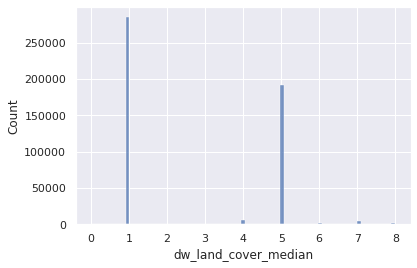

In [93]:
sns.histplot(gedi_burned, x="dw_land_cover_median")

In [94]:
gedi_burned = gedi_burned[gedi_burned.dw_land_cover_median.isin([1, 5])]

# Low severity

In [111]:
columns_to_use = ['rh_98_rel',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'gridded_pft_class',
                  'burn_year',
                  'burn_count',
                  'time_since_burn',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median',
                  'dw_land_cover_median']
m, xs, y = train_rf(high_severity, columns_to_use, "rh_98_rel", log=False)

0.380617 0.36570624439284416


                        cols       imp
10              slope_median  0.213165
5                  burn_year  0.140444
9           elevation_median  0.110378
1   elevation_difference_tdx  0.105526
2            solar_elevation  0.100576
3             sensitivity_a0  0.079697
7            time_since_burn  0.075846
8              aspect_median  0.053807
12      dw_land_cover_median  0.044751
11               soil_median  0.040182


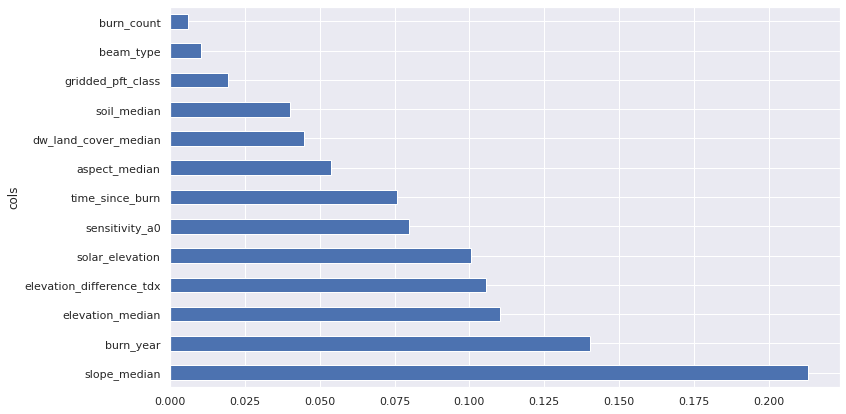

In [112]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

# Year by year

## 1st year

In [10]:
year_1 = gedi_burned[gedi_burned.time_since_burn == 1]

<AxesSubplot: >

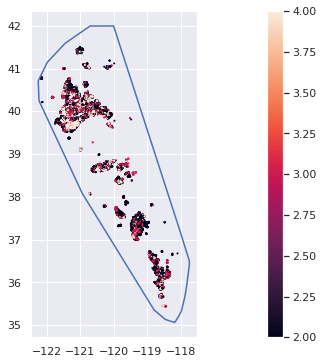

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sierras.boundary.plot(ax=ax)
year_1.plot(column="severity", legend=True, figsize=(15, 10), markersize=1, ax=ax)

<AxesSubplot: >

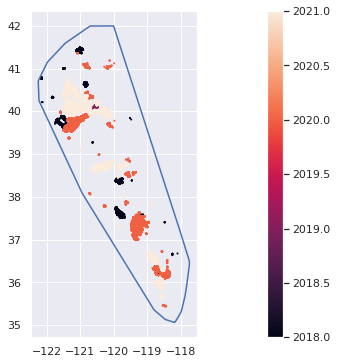

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sierras.boundary.plot(ax=ax)
year_1.plot(column="burn_year", legend=True, figsize=(15, 10), markersize=1, ax=ax)

<AxesSubplot: >

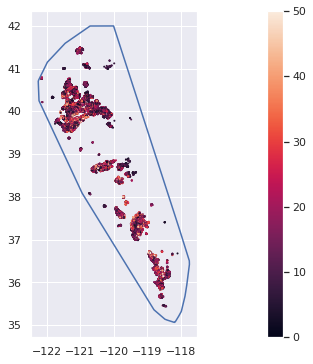

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sierras.boundary.plot(ax=ax)
year_1.plot(column="rh_98", legend=True, figsize=(15, 10), markersize=1, ax=ax, vmin=0,  vmax=50)

<AxesSubplot: xlabel='burn_year', ylabel='Count'>

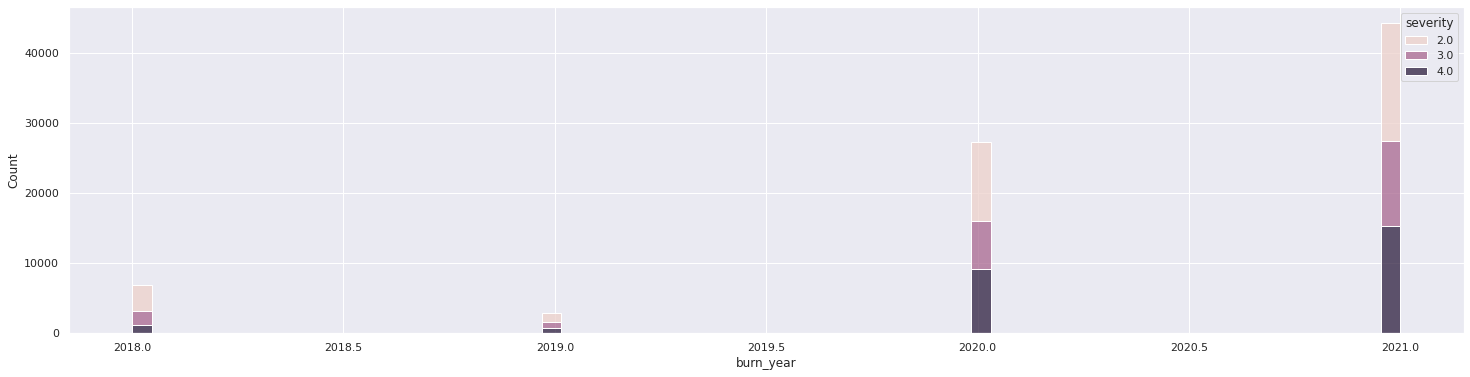

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.histplot(year_1, x="burn_year", hue="severity", multiple="stack")

<AxesSubplot: xlabel='burn_year', ylabel='rh_98'>

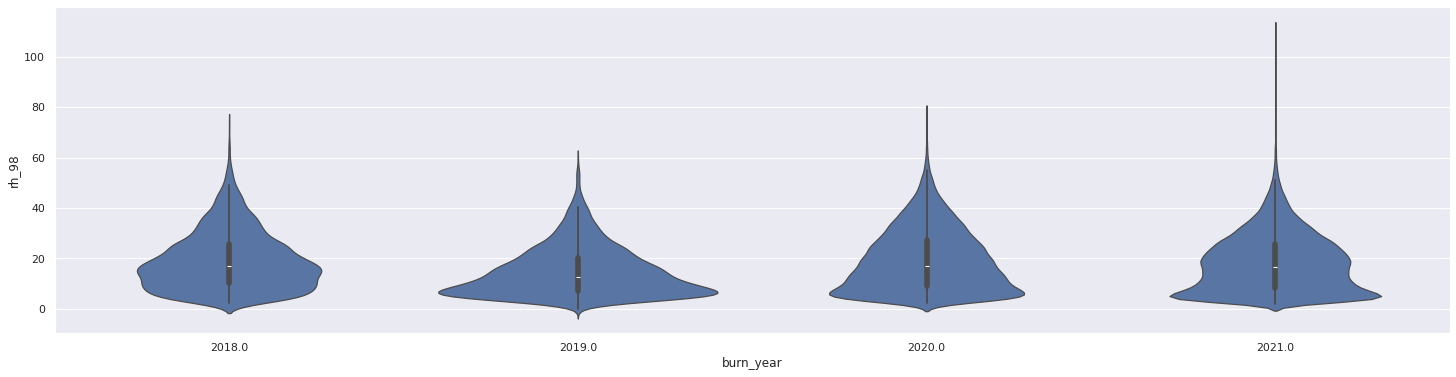

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.violinplot(year_1, x="burn_year", y="rh_98")

<AxesSubplot: xlabel='burn_year', ylabel='rh_98'>

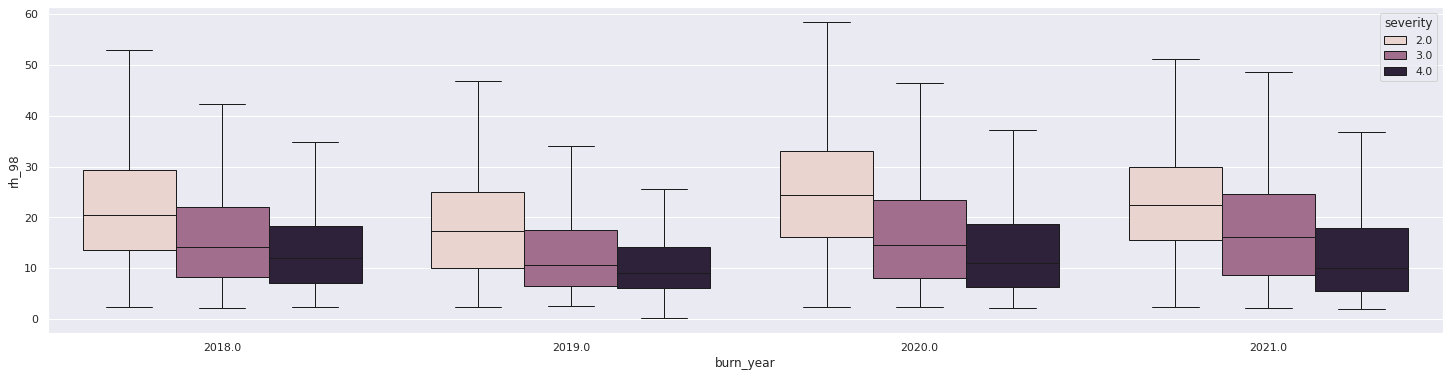

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.boxplot(year_1, x="burn_year", y="rh_98", hue="severity", showfliers=False)

<AxesSubplot: xlabel='burn_year', ylabel='rh_98_control'>

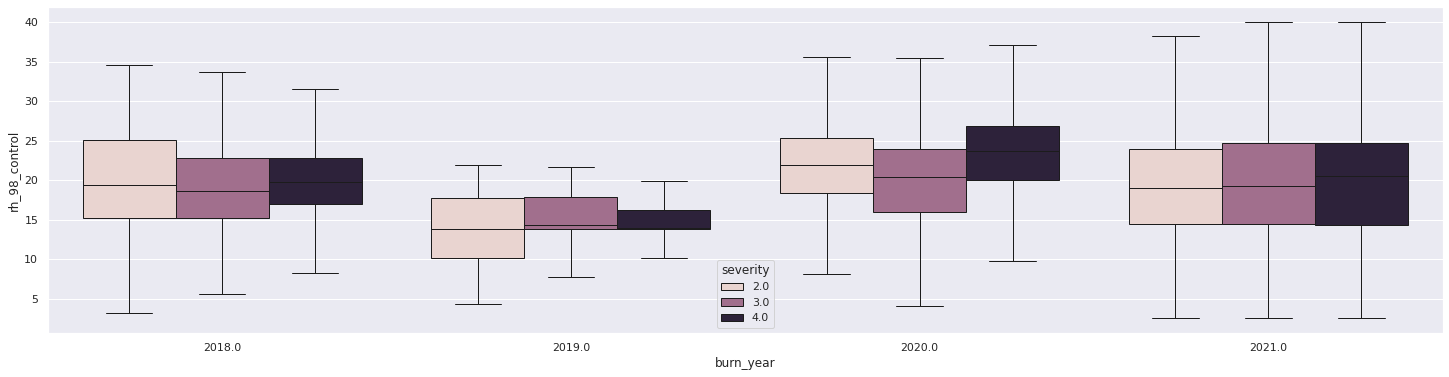

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.boxplot(year_1, x="burn_year", y="rh_98_control", hue="severity", showfliers=False)

<AxesSubplot: xlabel='burn_year', ylabel='rh_98_rel'>

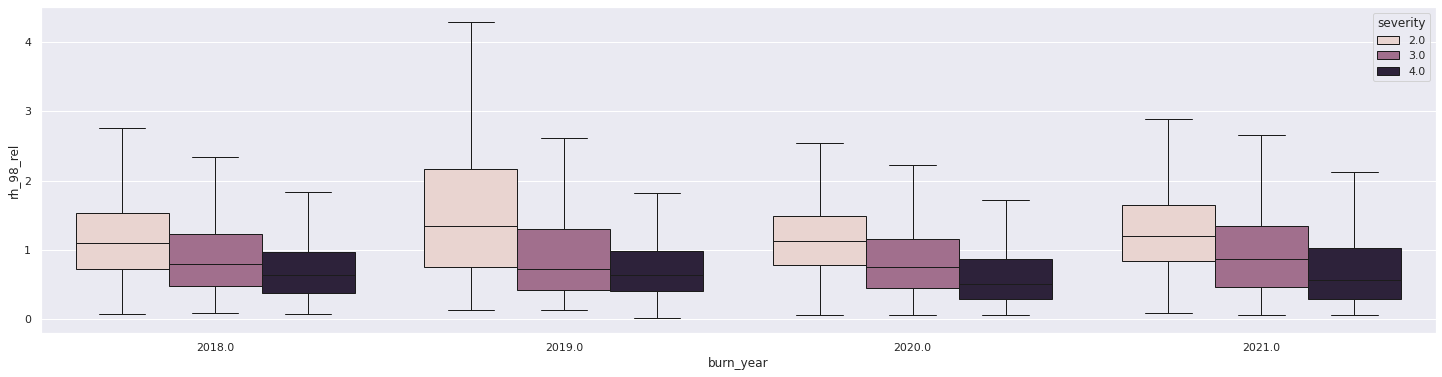

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.boxplot(year_1, x="burn_year", y="rh_98_rel", hue="severity", showfliers=False)

# High Severity

In [63]:
high_severity = gedi_burned[(gedi_burned.severity == 4) & (gedi_burned.time_since_burn < 36)]

In [64]:
high_severity[["rh_98", "rh_98_control", "rh_98_rel", "NDVI_mean", "slope_median", "elevation_median", "dw_land_cover_median", "elevation_difference_tdx", "longitude", "latitude", "time_since_burn", "burn_year"]].corr()

rh_98  rh_98_control  rh_98_rel  NDVI_mean  \
rh_98                     1.000000       0.178820   0.732949   0.142229   
rh_98_control             0.178820       1.000000  -0.343998   0.178320   
rh_98_rel                 0.732949      -0.343998   1.000000   0.004517   
NDVI_mean                 0.142229       0.178320   0.004517   1.000000   
slope_median              0.327849       0.059769   0.257522  -0.003865   
elevation_median         -0.168793      -0.224081  -0.018409  -0.270990   
dw_land_cover_median     -0.225227      -0.081341  -0.142571  -0.376381   
elevation_difference_tdx -0.268401      -0.204024  -0.128106   0.131448   
longitude                -0.081237      -0.275441   0.064000  -0.216238   
latitude                  0.004034       0.123185  -0.045381   0.122582   
time_since_burn           0.016620      -0.155381   0.055422   0.612309   
burn_year                -0.009706       0.155086  -0.047899  -0.621359   

                          slope_median  elevation_median  \
rh_98                         0.327849         -0.168793   
rh_98_control                 0.059769         -0.224081   
rh_98_rel                     0.257522         -0.018409   
NDVI_mean                    -0.003865         -0.270990   
slope_median                  1.000000          0.050383   
elevation_median              0.050383          1.000000   
dw_land_cover_median         -0.037227          0.202528   
elevation_difference_tdx     -0.131326          0.089951   
longitude                     0.235044          0.581764   
latitude                     -0.259713         -0.339929   
time_since_burn              -0.110856         -0.072482   
burn_year                     0.111019          0.072023   

                          dw_land_cover_median  elevation_difference_tdx  \
rh_98                                -0.225227                 -0.268401   
rh_98_control                        -0.081341                 -0.204024   
rh_98_rel                            -0.142571                 -0.128106   
NDVI_mean                            -0.376381                  0.131448   
slope_median                         -0.037227                 -0.131326   
elevation_median                      0.202528                  0.089951   
dw_land_cover_median                  1.000000                  0.001144   
elevation_difference_tdx              0.001144                  1.000000   
longitude                             0.191599                  0.055039   
latitude                             -0.134060                 -0.014320   
time_since_burn                      -0.321480                  0.339295   
burn_year                             0.321466                 -0.345543   

                          longitude  latitude  time_since_burn  burn_year  
rh_98                     -0.081237  0.004034         0.016620  -0.009706  
rh_98_control             -0.275441  0.123185        -0.155381   0.155086  
rh_98_rel                  0.064000 -0.045381         0.055422  -0.047899  
NDVI_mean                 -0.216238  0.122582         0.612309  -0.621359  
slope_median               0.235044 -0.259713        -0.110856   0.111019  
elevation_median           0.581764 -0.339929        -0.072482   0.072023  
dw_land_cover_median       0.191599 -0.134060        -0.321480   0.321466  
elevation_difference_tdx   0.055039 -0.014320         0.339295  -0.345543  
longitude                  1.000000 -0.926317        -0.051139   0.042933  
latitude                  -0.926317  1.000000         0.043867  -0.036132  
time_since_burn           -0.051139  0.043867         1.000000  -0.994417  
burn_year                  0.042933 -0.036132        -0.994417   1.000000

<AxesSubplot: xlabel='time_since_burn', ylabel='Count'>

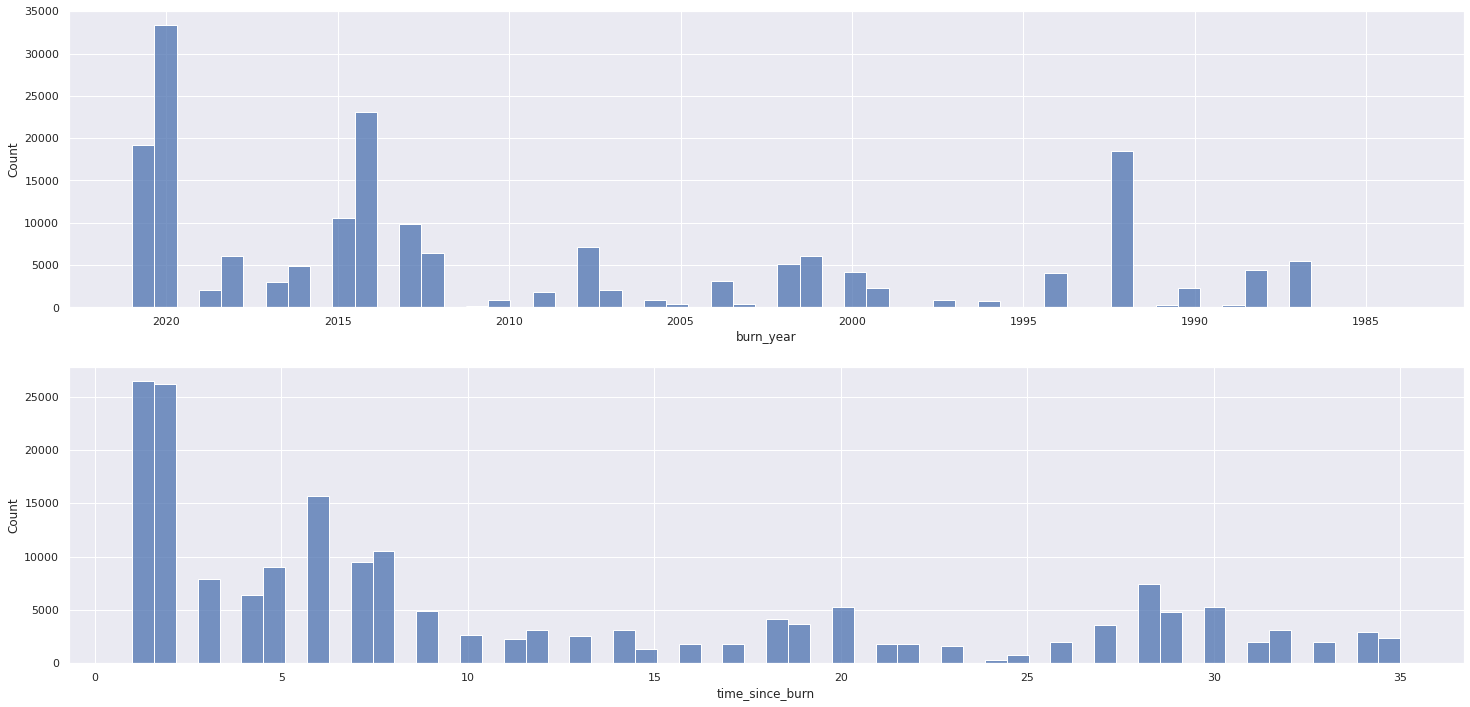

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.histplot(high_severity, x="burn_year", ax=ax[0])
ax[0].invert_xaxis()
sns.histplot(high_severity, x="time_since_burn", ax=ax[1])

# Fit Medians

In [162]:
gedi_burned = gedi_burned.dropna()
gedi_burned = gedi_burned[gedi_burned.time_since_burn < 36]

In [163]:
rh_98_rel_medians = gedi_burned.groupby("time_since_burn").rh_98_rel.median()
slope_medians = gedi_burned.groupby("time_since_burn").slope_median.median()
elevation_medians = gedi_burned.groupby("time_since_burn").elevation_median.median()
elevation_difference_tdx_medians = gedi_burned.groupby("time_since_burn").elevation_difference_tdx.median()

<AxesSubplot: ylabel='rh_98_rel'>

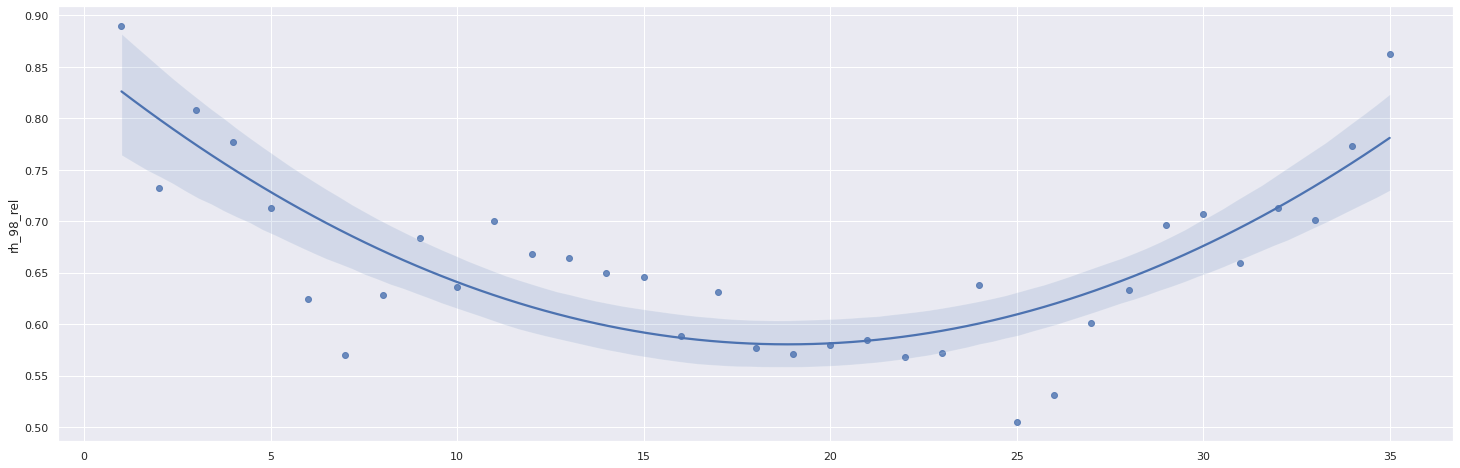

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(25, 8))
sns.regplot(x=pd.Series(range(1, 36)), y=rh_98_rel_medians, ax=ax, order=2)

In [154]:
rh_98_rel_medians = low_severity.groupby("time_since_burn").rh_98_rel.median()
slope_medians = low_severity.groupby("time_since_burn").slope_median.median()
elevation_medians = low_severity.groupby("time_since_burn").elevation_median.median()
elevation_difference_tdx_medians = low_severity.groupby("time_since_burn").elevation_difference_tdx.median()

<AxesSubplot: ylabel='rh_98_rel'>

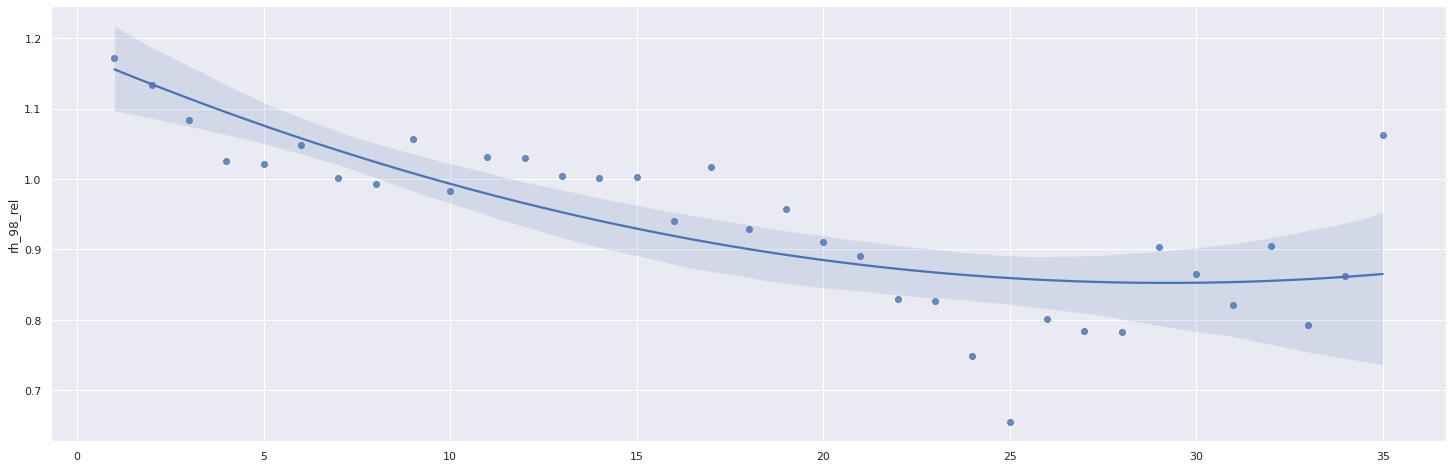

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(25, 8))
sns.regplot(x=pd.Series(range(1, 36)), y=rh_98_rel_medians, ax=ax, order=2)

In [142]:
print(rh_98_rel_medians.corr(slope_medians))
print(rh_98_rel_medians.corr(elevation_medians))
print(rh_98_rel_medians.corr(elevation_difference_tdx_medians))

0.6917242110774694
0.5167841211402743
-0.7823289882294234


In [145]:
from scipy.stats import pearsonr
print(pearsonr(rh_98_rel_medians, slope_medians))
print(pearsonr(rh_98_rel_medians, elevation_medians))
print(pearsonr(rh_98_rel_medians, elevation_difference_tdx_medians))
print(pearsonr(rh_98_rel_medians, range(1, 36)))

PearsonRResult(statistic=0.6917242110774696, pvalue=4.18548092316219e-06)
PearsonRResult(statistic=0.516784121140274, pvalue=0.0014803300601003398)
PearsonRResult(statistic=-0.7823289882294232, pvalue=2.8409098986451283e-08)
PearsonRResult(statistic=-0.7417665929600898, pvalue=3.420000682401353e-07)


In [146]:
rh_98_rel_medians = high_severity.groupby("time_since_burn").rh_98_rel.median()
slope_medians = high_severity.groupby("time_since_burn").slope_median.median()
elevation_medians = high_severity.groupby("time_since_burn").elevation_median.median()
elevation_difference_tdx_medians = high_severity.groupby("time_since_burn").elevation_difference_tdx.median()

In [147]:
from scipy.stats import pearsonr
print(pearsonr(rh_98_rel_medians, slope_medians))
print(pearsonr(rh_98_rel_medians, elevation_medians))
print(pearsonr(rh_98_rel_medians, elevation_difference_tdx_medians))
print(pearsonr(rh_98_rel_medians, range(1, 36)))

PearsonRResult(statistic=-0.12628676405263667, pvalue=0.469746811084944)
PearsonRResult(statistic=-0.38737706555695683, pvalue=0.021498496347989532)
PearsonRResult(statistic=0.11756902417743159, pvalue=0.5011852852347647)
PearsonRResult(statistic=0.7035030471269336, pvalue=2.430665969587812e-06)


(0.0, 1.0)

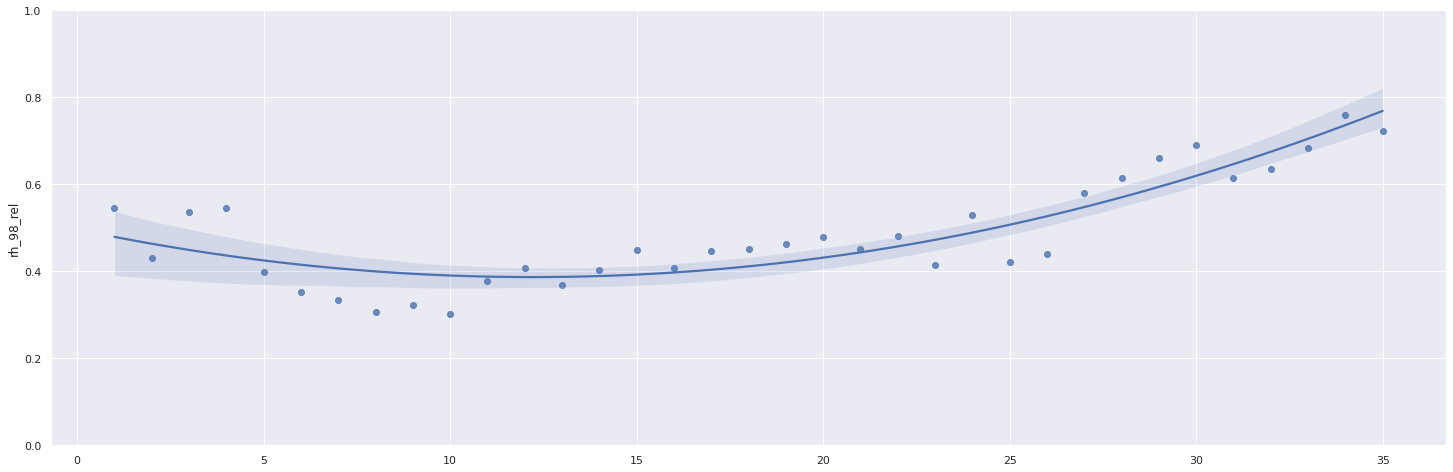

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(25, 8))
sns.regplot(x=pd.Series(range(1, 36)), y=rh_98_rel_medians, ax=ax, order=2)
ax.set_ylim((0, 1))

# Low Severity

In [95]:
low_severity = gedi_burned[(gedi_burned.severity == 2) & (gedi_burned.time_since_burn < 36)]

In [118]:
import scipy as sp
import statsmodels.api as sm

In [121]:
low_severity = low_severity.dropna()

In [125]:
y = low_severity.rh_98.to_numpy()
x1 = low_severity.slope_median.to_numpy()
x2 = low_severity.elevation_median.to_numpy()
x3 = low_severity.elevation_difference_tdx.to_numpy()
x4 = low_severity.time_since_burn.to_numpy()
X = sm.add_constant(np.stack([x1, x2, x3, x4]).T)
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary(xname=['const', 'x1', 'x2', 'x3', 'x4']))  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                 1.532e+04
Date:                Sun, 29 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:18:35   Log-Likelihood:            -6.2837e+05
No. Observations:              166962   AIC:                         1.257e+06
Df Residuals:                  166957   BIC:                         1.257e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6521      0.099    138.187      0.0

In [128]:
y = low_severity.rh_98_rel.to_numpy()
x1 = low_severity.slope_median.to_numpy()
x2 = low_severity.elevation_median.to_numpy()
x3 = low_severity.elevation_difference_tdx.to_numpy()
x4 = low_severity.time_since_burn.to_numpy()
X = sm.add_constant(np.stack([x1, x2, x3, x4, x4**2]).T)
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary(xname=['const', 'x1', 'x2', 'x3', 'x4', 'x5']))  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     2751.
Date:                Sun, 29 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:20:53   Log-Likelihood:            -1.7262e+05
No. Observations:              166962   AIC:                         3.453e+05
Df Residuals:                  166957   BIC:                         3.453e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8892      0.006    145.249      0.0

In [130]:
high_severity = high_severity.dropna()
y = high_severity.rh_98_rel.to_numpy()
x1 = high_severity.slope_median.to_numpy()
x2 = high_severity.elevation_median.to_numpy()
x3 = high_severity.elevation_difference_tdx.to_numpy()
x4 = high_severity.time_since_burn.to_numpy()
X = sm.add_constant(np.stack([x1, x2, x3, x4, x4**2]).T)
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary(xname=['const', 'x1', 'x2', 'x3', 'x4', 'x5']))  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     5092.
Date:                Sun, 29 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:22:08   Log-Likelihood:            -1.1755e+05
No. Observations:              190268   AIC:                         2.351e+05
Df Residuals:                  190262   BIC:                         2.352e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3487      0.004     78.723      0.0

In [96]:
low_severity.columns

Index(['shot_number', 'beam_type', 'absolute_time', 'longitude', 'latitude',
       'elevation_difference_tdx', 'agbd', 'agbd_se', 'fhd_normal', 'pai',
       'pai_z', 'pavd_z', 'rh_98', 'rh_70', 'rh_50', 'rh_25', 'cover',
       'cover_z', 'sensitivity_a0', 'solar_elevation', 'gridded_pft_class',
       'geometry', 'gedi_year', 'gedi_month', 'severity', 'burn_year',
       'burn_count', 'time_since_burn', 'aspect_2x2', 'aspect_mean',
       'aspect_std', 'aspect_median', 'elevation_2x2', 'elevation_mean',
       'elevation_std', 'elevation_median', 'slope_2x2', 'slope_mean',
       'slope_std', 'slope_median', 'soil_2x2', 'soil_mean', 'soil_std',
       'soil_median', 'SR_B1_2x2', 'SR_B1_mean', 'SR_B1_std', 'SR_B1_median',
       'SR_B2_2x2', 'SR_B2_mean', 'SR_B2_std', 'SR_B2_median', 'SR_B3_2x2',
       'SR_B3_mean', 'SR_B3_std', 'SR_B3_median', 'SR_B4_2x2', 'SR_B4_mean',
       'SR_B4_std', 'SR_B4_median', 'SR_B5_2x2', 'SR_B5_mean', 'SR_B5_std',
       'SR_B5_median', 'SR_B6_2x2', '

In [97]:
low_severity[["rh_98", "rh_98_control", "rh_98_rel", "NDVI_mean", "slope_median", "elevation_median", "dw_land_cover_median", "elevation_difference_tdx", "longitude", "latitude", "time_since_burn", "burn_year"]].corr()

rh_98  rh_98_control  rh_98_rel  NDVI_mean  \
rh_98                     1.000000       0.455625   0.613634   0.460766   
rh_98_control             0.455625       1.000000  -0.264314   0.506293   
rh_98_rel                 0.613634      -0.264314   1.000000   0.091192   
NDVI_mean                 0.460766       0.506293   0.091192   1.000000   
slope_median              0.196877       0.200902   0.057422   0.162888   
elevation_median          0.118590       0.043934   0.093247  -0.267893   
dw_land_cover_median     -0.393258      -0.264944  -0.211059  -0.586086   
elevation_difference_tdx -0.472892      -0.300622  -0.224809  -0.289235   
longitude                 0.037604      -0.071393   0.068126  -0.262185   
latitude                 -0.071198      -0.018402  -0.018155   0.111677   
time_since_burn          -0.241140      -0.190578  -0.136156   0.106566   
burn_year                 0.237161       0.185891   0.135889  -0.117576   

                          slope_median  elevation_median  \
rh_98                         0.196877          0.118590   
rh_98_control                 0.200902          0.043934   
rh_98_rel                     0.057422          0.093247   
NDVI_mean                     0.162888         -0.267893   
slope_median                  1.000000         -0.147039   
elevation_median             -0.147039          1.000000   
dw_land_cover_median         -0.026499          0.098325   
elevation_difference_tdx     -0.150225         -0.036769   
longitude                     0.142367          0.604815   
latitude                     -0.231700         -0.356466   
time_since_burn              -0.097677         -0.247539   
burn_year                     0.096050          0.258134   

                          dw_land_cover_median  elevation_difference_tdx  \
rh_98                                -0.393258                 -0.472892   
rh_98_control                        -0.264944                 -0.300622   
rh_98_rel                            -0.211059                 -0.224809   
NDVI_mean                            -0.586086                 -0.289235   
slope_median                         -0.026499                 -0.150225   
elevation_median                      0.098325                 -0.036769   
dw_land_cover_median                  1.000000                  0.243796   
elevation_difference_tdx              0.243796                  1.000000   
longitude                             0.123775                 -0.028866   
latitude                             -0.044563                  0.067767   
time_since_burn                       0.025364                  0.191086   
burn_year                            -0.024737                 -0.192730   

                          longitude  latitude  time_since_burn  burn_year  
rh_98                      0.037604 -0.071198        -0.241140   0.237161  
rh_98_control             -0.071393 -0.018402        -0.190578   0.185891  
rh_98_rel                  0.068126 -0.018155        -0.136156   0.135889  
NDVI_mean                 -0.262185  0.111677         0.106566  -0.117576  
slope_median               0.142367 -0.231700        -0.097677   0.096050  
elevation_median           0.604815 -0.356466        -0.247539   0.258134  
dw_land_cover_median       0.123775 -0.044563         0.025364  -0.024737  
elevation_difference_tdx  -0.028866  0.067767         0.191086  -0.192730  
longitude                  1.000000 -0.918090        -0.213258   0.218046  
latitude                  -0.918090  1.000000         0.168141  -0.171702  
time_since_burn           -0.213258  0.168141         1.000000  -0.993349  
burn_year                  0.218046 -0.171702        -0.993349   1.000000

In [99]:
low_severity[low_severity.elevation_difference_tdx > -10][["rh_98", "rh_98_control", "rh_98_rel", "NDVI_mean", "slope_median", "elevation_median", "dw_land_cover_median", "elevation_difference_tdx", "longitude", "latitude", "time_since_burn", "burn_year"]].corr()

rh_98  rh_98_control  rh_98_rel  NDVI_mean  \
rh_98                     1.000000       0.383729   0.589413   0.372713   
rh_98_control             0.383729       1.000000  -0.332985   0.451564   
rh_98_rel                 0.589413      -0.332985   1.000000   0.021045   
NDVI_mean                 0.372713       0.451564   0.021045   1.000000   
slope_median              0.262283       0.265435   0.048918   0.176333   
elevation_median          0.172318       0.117940   0.084217  -0.236879   
dw_land_cover_median     -0.341829      -0.196438  -0.175236  -0.582824   
elevation_difference_tdx -0.094331      -0.016883  -0.079266  -0.042041   
longitude                 0.120697       0.053539   0.048004  -0.201266   
latitude                 -0.125182      -0.149194   0.035086   0.031258   
time_since_burn          -0.211056      -0.173925  -0.115864   0.168047   
burn_year                 0.210051       0.174756   0.114736  -0.176205   

                          slope_median  elevation_median  \
rh_98                         0.262283          0.172318   
rh_98_control                 0.265435          0.117940   
rh_98_rel                     0.048918          0.084217   
NDVI_mean                     0.176333         -0.236879   
slope_median                  1.000000         -0.091436   
elevation_median             -0.091436          1.000000   
dw_land_cover_median         -0.031162          0.141094   
elevation_difference_tdx      0.304484         -0.067325   
longitude                     0.235639          0.587549   
latitude                     -0.343914         -0.281132   
time_since_burn              -0.130777         -0.240464   
burn_year                     0.132186          0.249369   

                          dw_land_cover_median  elevation_difference_tdx  \
rh_98                                -0.341829                 -0.094331   
rh_98_control                        -0.196438                 -0.016883   
rh_98_rel                            -0.175236                 -0.079266   
NDVI_mean                            -0.582824                 -0.042041   
slope_median                         -0.031162                  0.304484   
elevation_median                      0.141094                 -0.067325   
dw_land_cover_median                  1.000000                  0.093267   
elevation_difference_tdx              0.093267                  1.000000   
longitude                             0.142278                  0.099978   
latitude                             -0.053978                 -0.125773   
time_since_burn                      -0.046634                  0.031897   
burn_year                             0.046147                 -0.030542   

                          longitude  latitude  time_since_burn  burn_year  
rh_98                      0.120697 -0.125182        -0.211056   0.210051  
rh_98_control              0.053539 -0.149194        -0.173925   0.174756  
rh_98_rel                  0.048004  0.035086        -0.115864   0.114736  
NDVI_mean                 -0.201266  0.031258         0.168047  -0.176205  
slope_median               0.235639 -0.343914        -0.130777   0.132186  
elevation_median           0.587549 -0.281132        -0.240464   0.249369  
dw_land_cover_median       0.142278 -0.053978        -0.046634   0.046147  
elevation_difference_tdx   0.099978 -0.125773         0.031897  -0.030542  
longitude                  1.000000 -0.892121        -0.244616   0.250474  
latitude                  -0.892121  1.000000         0.180704  -0.186686  
time_since_burn           -0.244616  0.180704         1.000000  -0.994371  
burn_year                  0.250474 -0.186686        -0.994371   1.000000

In [100]:
low_10 = low_severity[low_severity.time_since_burn < 11]
low_20 = low_severity[(low_severity.time_since_burn < 32) & (low_severity.time_since_burn >= 22)]

(0.0, 5.0)

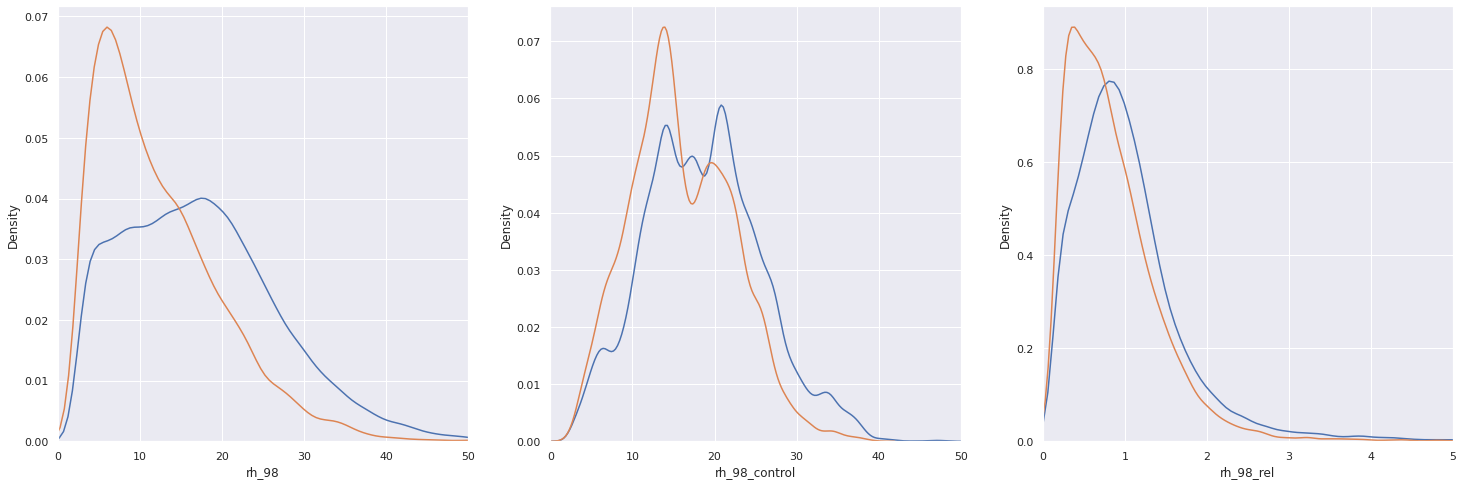

In [101]:
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
sns.kdeplot(low_10[low_10.elevation_difference_tdx > -10], x="rh_98", ax=ax[0])
sns.kdeplot(low_20[low_20.elevation_difference_tdx > -10], x="rh_98", ax=ax[0])
sns.kdeplot(low_10[low_10.elevation_difference_tdx > -10], x="rh_98_control", ax=ax[1])
sns.kdeplot(low_20[low_20.elevation_difference_tdx > -10], x="rh_98_control", ax=ax[1])
sns.kdeplot(low_10[low_10.elevation_difference_tdx > -10], x="rh_98_rel", ax=ax[2])
sns.kdeplot(low_20[low_20.elevation_difference_tdx > -10], x="rh_98_rel", ax=ax[2])
ax[0].set_xlim((0, 50))
ax[1].set_xlim((0, 50))
ax[2].set_xlim((0, 5))

(0.0, 5.0)

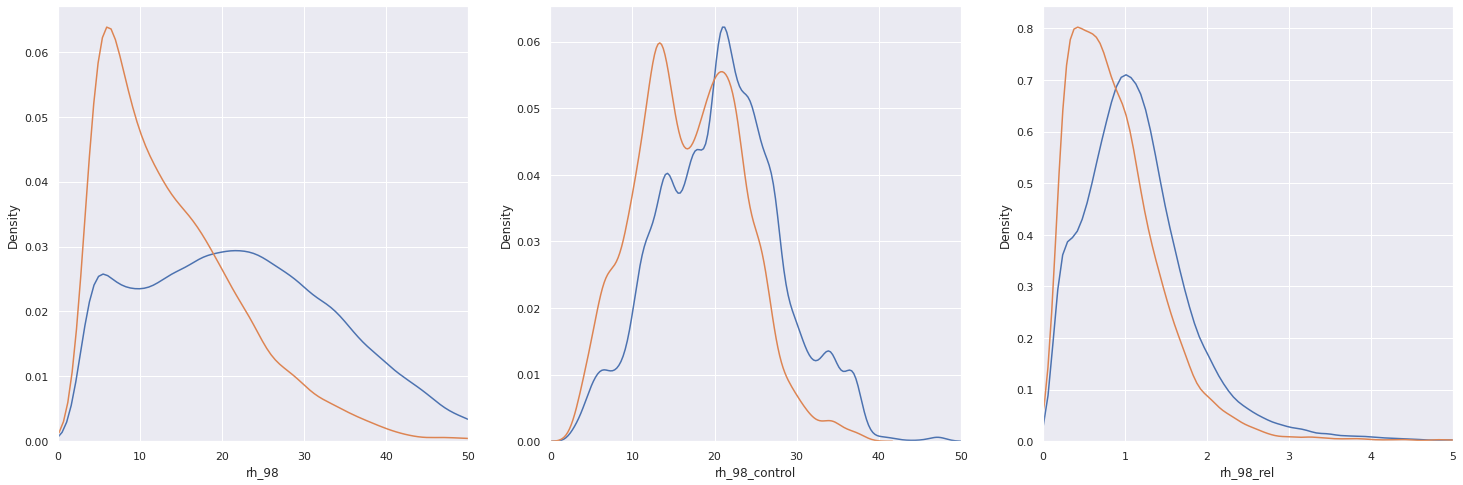

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
sns.kdeplot(low_10[(low_10.slope_median > 5) & (low_10.slope_median < 20)], x="rh_98", ax=ax[0])
sns.kdeplot(low_20[(low_20.slope_median > 5) & (low_20.slope_median < 20)], x="rh_98", ax=ax[0])
sns.kdeplot(low_10[(low_10.slope_median > 5) & (low_10.slope_median < 20)], x="rh_98_control", ax=ax[1])
sns.kdeplot(low_20[(low_20.slope_median > 5) & (low_20.slope_median < 20)], x="rh_98_control", ax=ax[1])
sns.kdeplot(low_10[(low_10.slope_median > 5) & (low_10.slope_median < 20)], x="rh_98_rel", ax=ax[2])
sns.kdeplot(low_20[(low_20.slope_median > 5) & (low_20.slope_median < 20)], x="rh_98_rel", ax=ax[2])
ax[0].set_xlim((0, 50))
ax[1].set_xlim((0, 50))
ax[2].set_xlim((0, 5))

(0.0, 5.0)

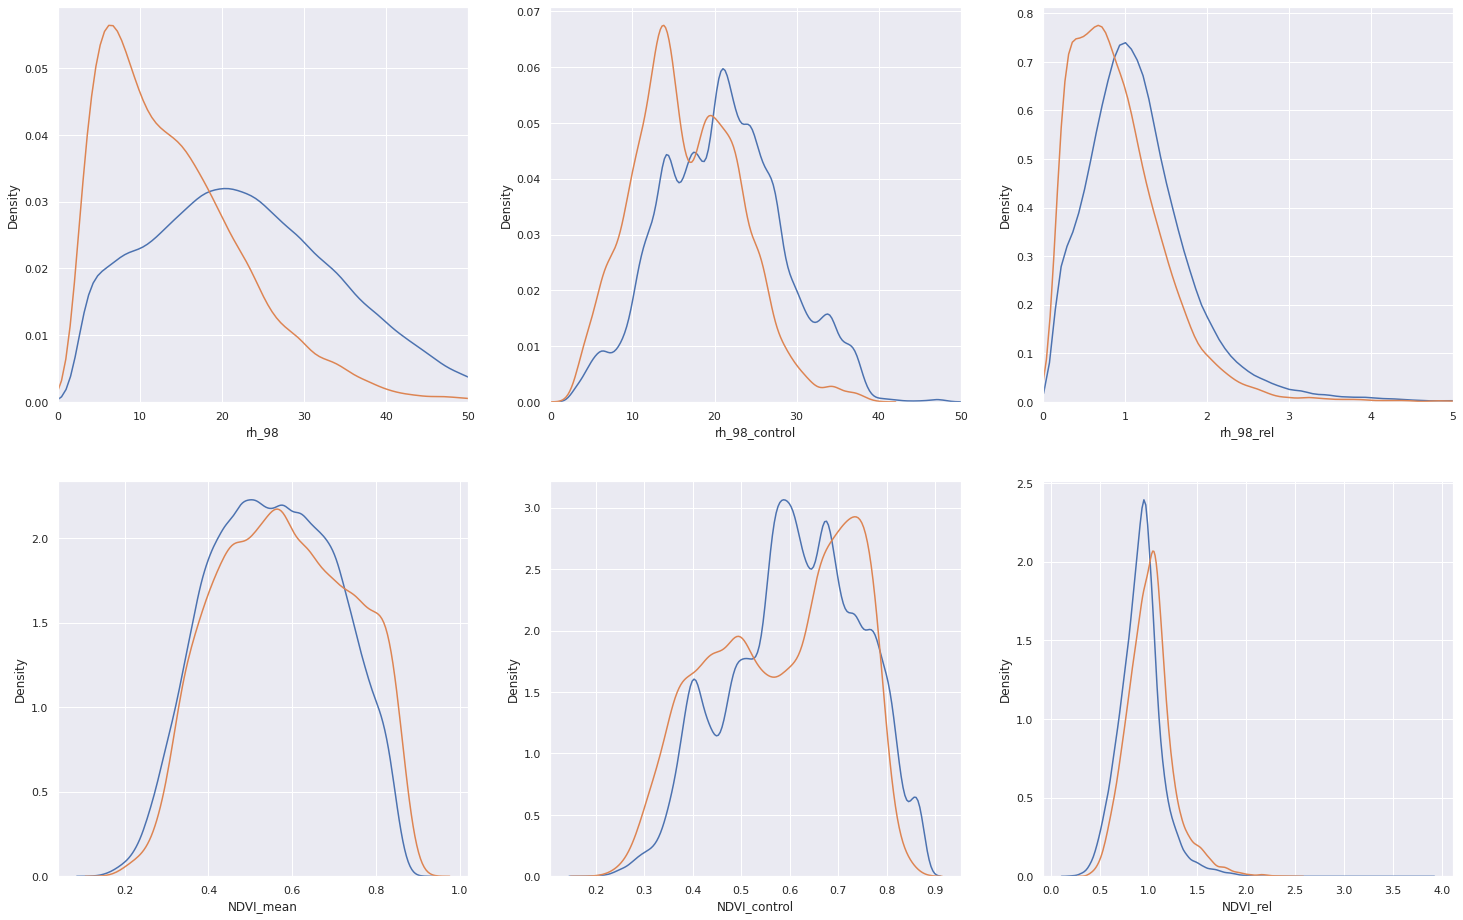

In [106]:
fig, ax = plt.subplots(2, 3, figsize=(25, 16))
sns.kdeplot(low_10, x="rh_98", ax=ax[0][0])
sns.kdeplot(low_20, x="rh_98", ax=ax[0][0])
sns.kdeplot(low_10, x="rh_98_control", ax=ax[0][1])
sns.kdeplot(low_20, x="rh_98_control", ax=ax[0][1])
sns.kdeplot(low_10, x="rh_98_rel", ax=ax[0][2])
sns.kdeplot(low_20, x="rh_98_rel", ax=ax[0][2])
sns.kdeplot(low_10, x="NDVI_mean", ax=ax[1][0])
sns.kdeplot(low_20, x="NDVI_mean", ax=ax[1][0])
sns.kdeplot(low_10, x="NDVI_control", ax=ax[1][1])
sns.kdeplot(low_20, x="NDVI_control", ax=ax[1][1])
sns.kdeplot(low_10, x="NDVI_rel", ax=ax[1][2])
sns.kdeplot(low_20, x="NDVI_rel", ax=ax[1][2])
ax[0][0].set_xlim((0, 50))
ax[0][1].set_xlim((0, 50))
ax[0][2].set_xlim((0, 5))

<AxesSubplot: xlabel='elevation_difference_tdx', ylabel='Density'>

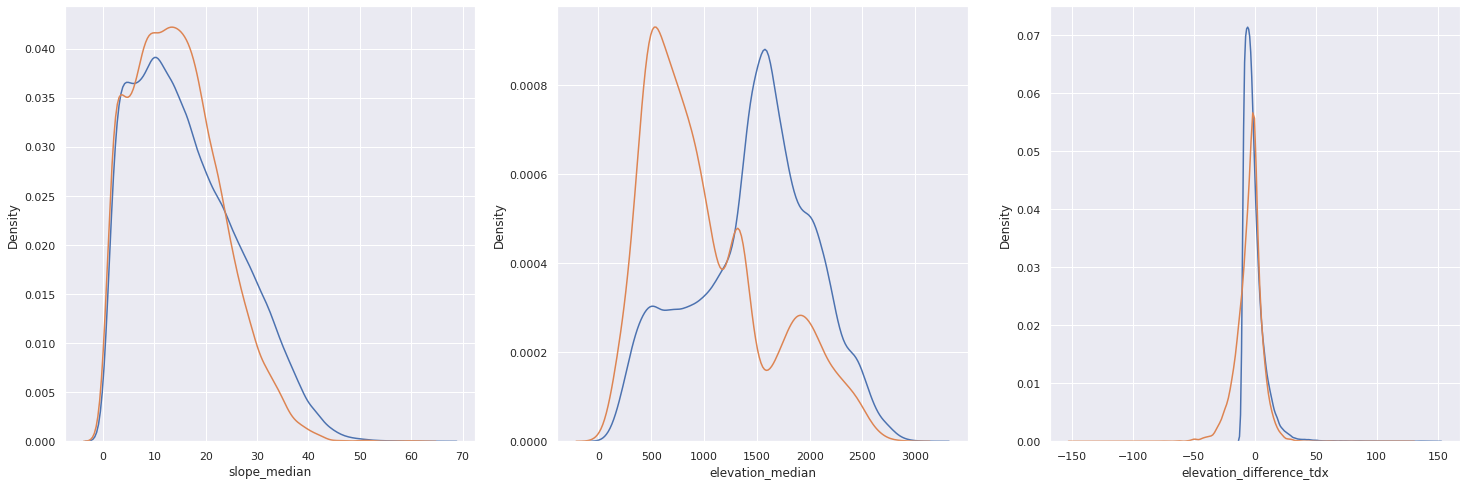

In [102]:
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
sns.kdeplot(low_10[low_10.elevation_difference_tdx > -10], x="slope_median", ax=ax[0])
sns.kdeplot(low_20, x="slope_median", ax=ax[0])
sns.kdeplot(low_10[low_10.elevation_difference_tdx > -10], x="elevation_median", ax=ax[1])
sns.kdeplot(low_20, x="elevation_median", ax=ax[1])
sns.kdeplot(low_10[low_10.elevation_difference_tdx > -10], x="elevation_difference_tdx", ax=ax[2])
sns.kdeplot(low_20, x="elevation_difference_tdx", ax=ax[2])

<AxesSubplot: xlabel='elevation_difference_tdx', ylabel='Density'>

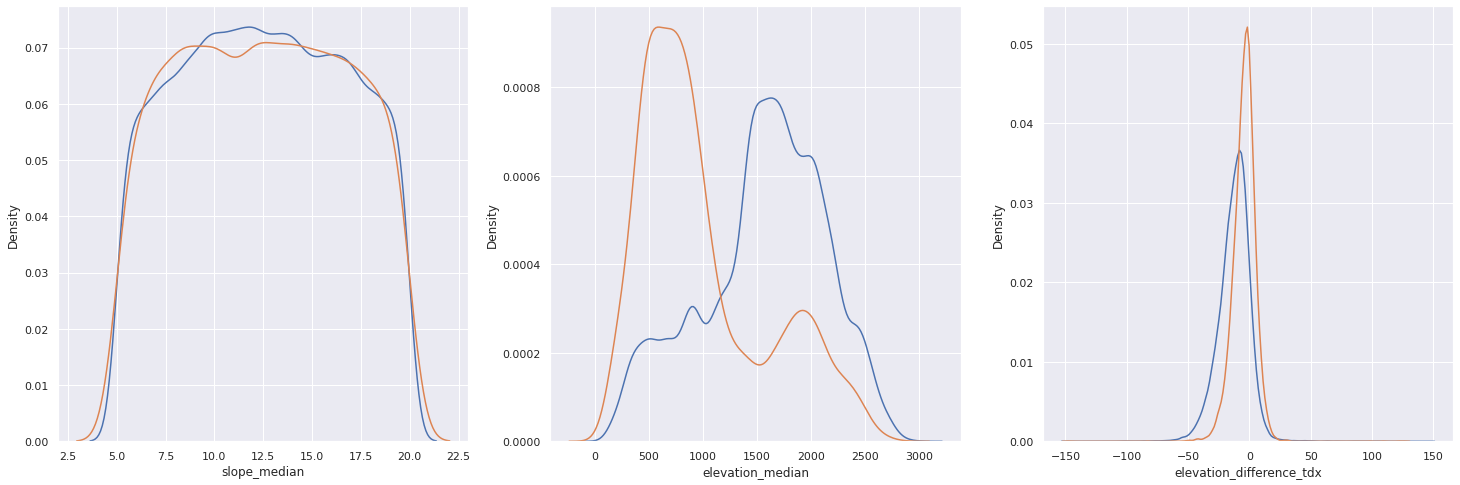

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
sns.kdeplot(low_10[(low_10.slope_median > 5) & (low_10.slope_median < 20)], x="slope_median", ax=ax[0])
sns.kdeplot(low_20[(low_20.slope_median > 5) & (low_20.slope_median < 20)], x="slope_median", ax=ax[0])
sns.kdeplot(low_10[(low_10.slope_median > 5) & (low_10.slope_median < 20)], x="elevation_median", ax=ax[1])
sns.kdeplot(low_20[(low_20.slope_median > 5) & (low_20.slope_median < 20)], x="elevation_median", ax=ax[1])
sns.kdeplot(low_10[(low_10.slope_median > 5) & (low_10.slope_median < 20)], x="elevation_difference_tdx", ax=ax[2])
sns.kdeplot(low_20[(low_20.slope_median > 5) & (low_20.slope_median < 20)], x="elevation_difference_tdx", ax=ax[2])

<AxesSubplot: xlabel='rh_98_control', ylabel='Density'>

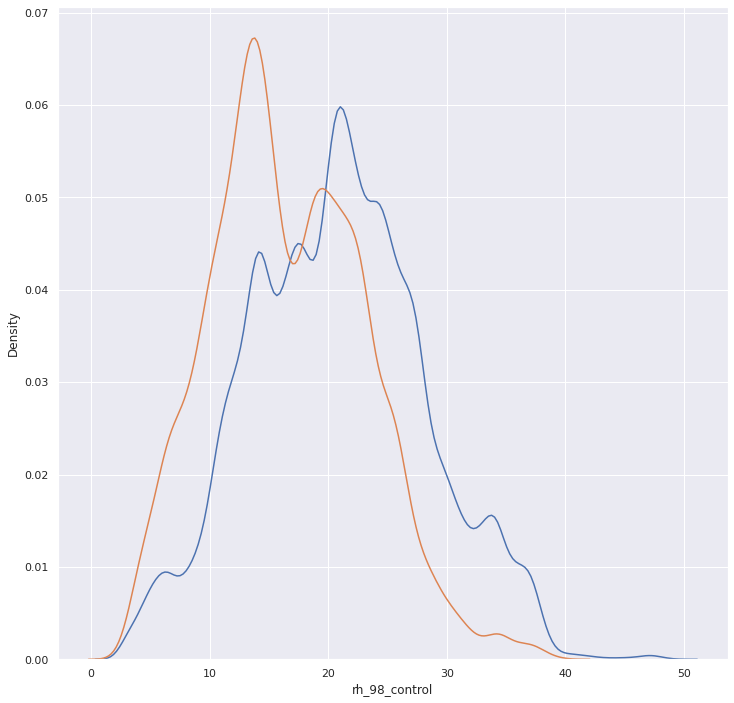

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.kdeplot(low_10, x="rh_98_control")
sns.kdeplot(low_20, x="rh_98_control")

<AxesSubplot: xlabel='time_since_burn', ylabel='Count'>

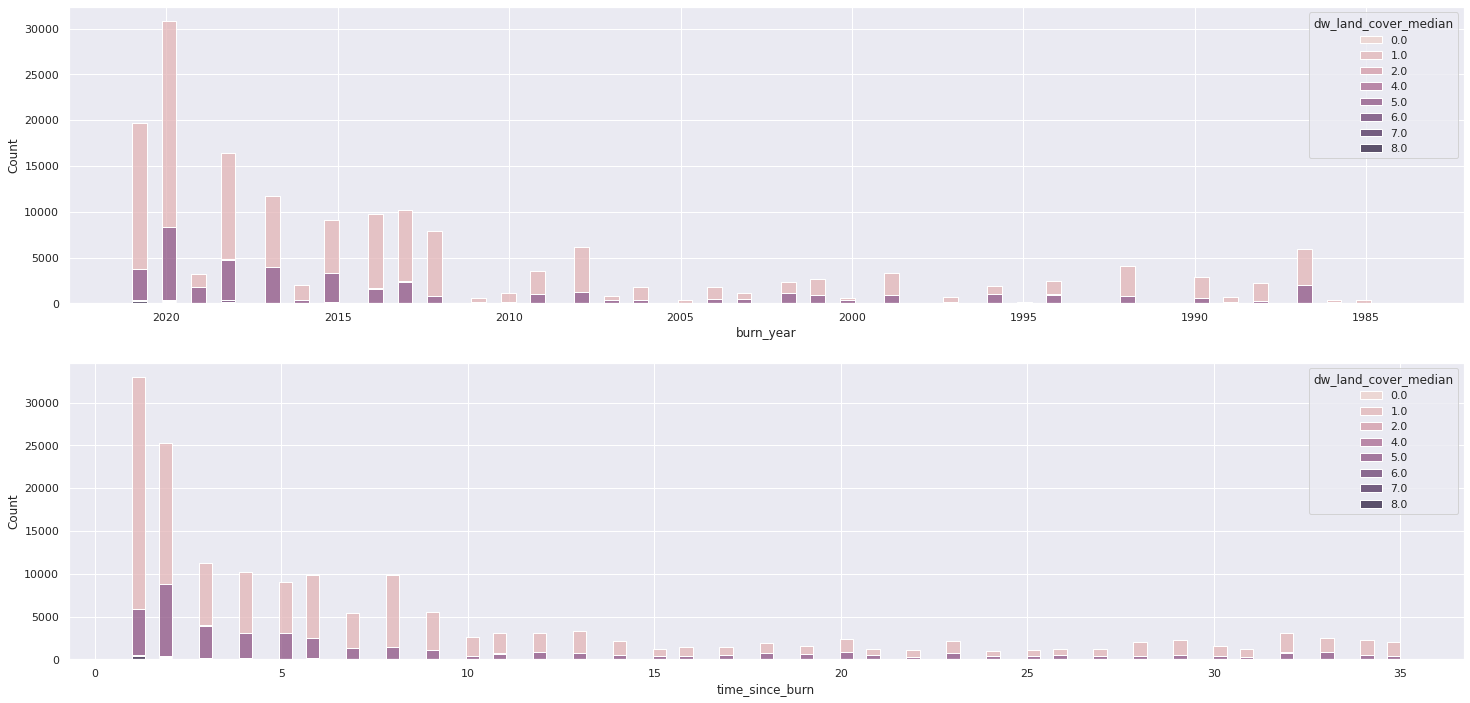

In [92]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.histplot(low_severity, x="burn_year", hue="dw_land_cover_median", ax=ax[0], multiple="stack")
ax[0].invert_xaxis()
sns.histplot(low_severity, x="time_since_burn", hue="dw_land_cover_median", ax=ax[1], multiple="stack")

(0.5, 1.5)

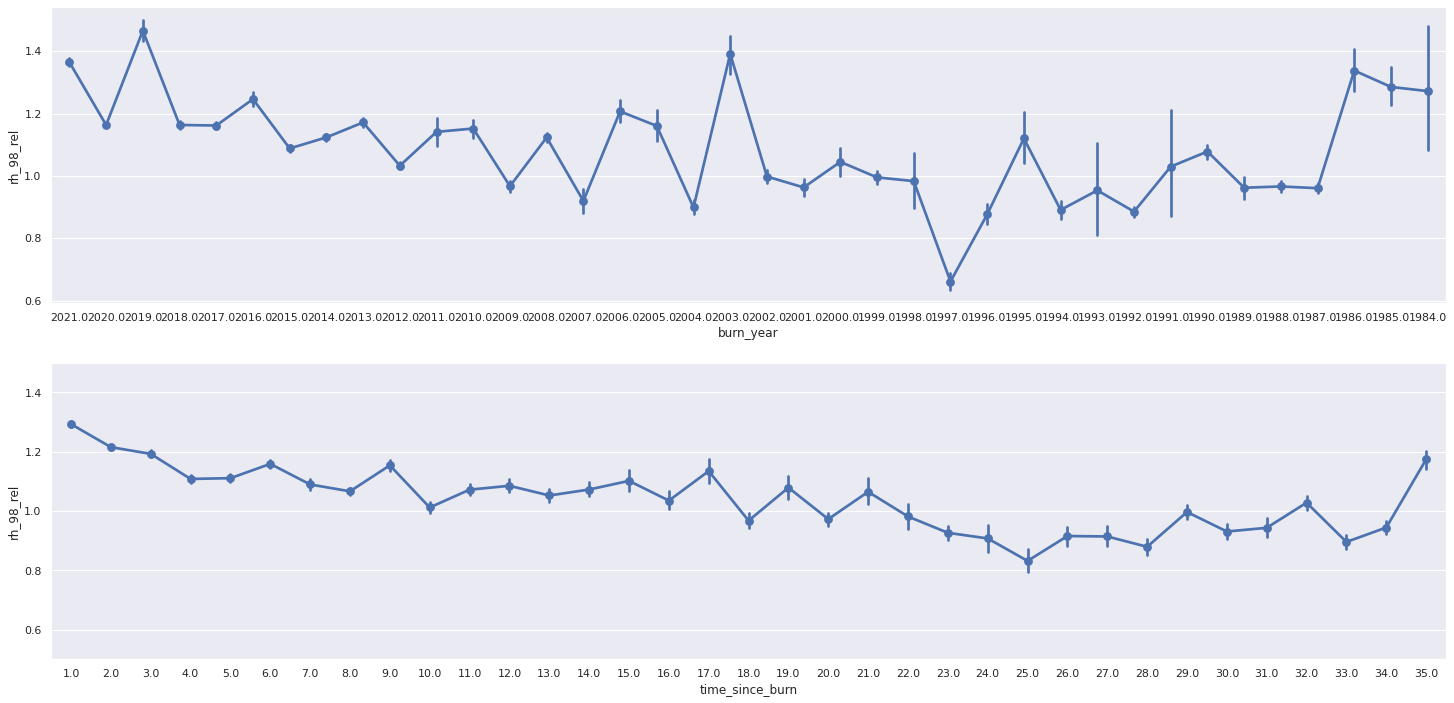

In [66]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.pointplot(low_severity, x="burn_year", y="rh_98_rel",  ax=ax[0])
ax[0].invert_xaxis()
sns.pointplot(low_severity, x="time_since_burn", y="rh_98_rel",  ax=ax[1])
ax[1].set_ylim((0.5, 1.5))

<AxesSubplot: xlabel='time_since_burn', ylabel='rh_98_rel'>

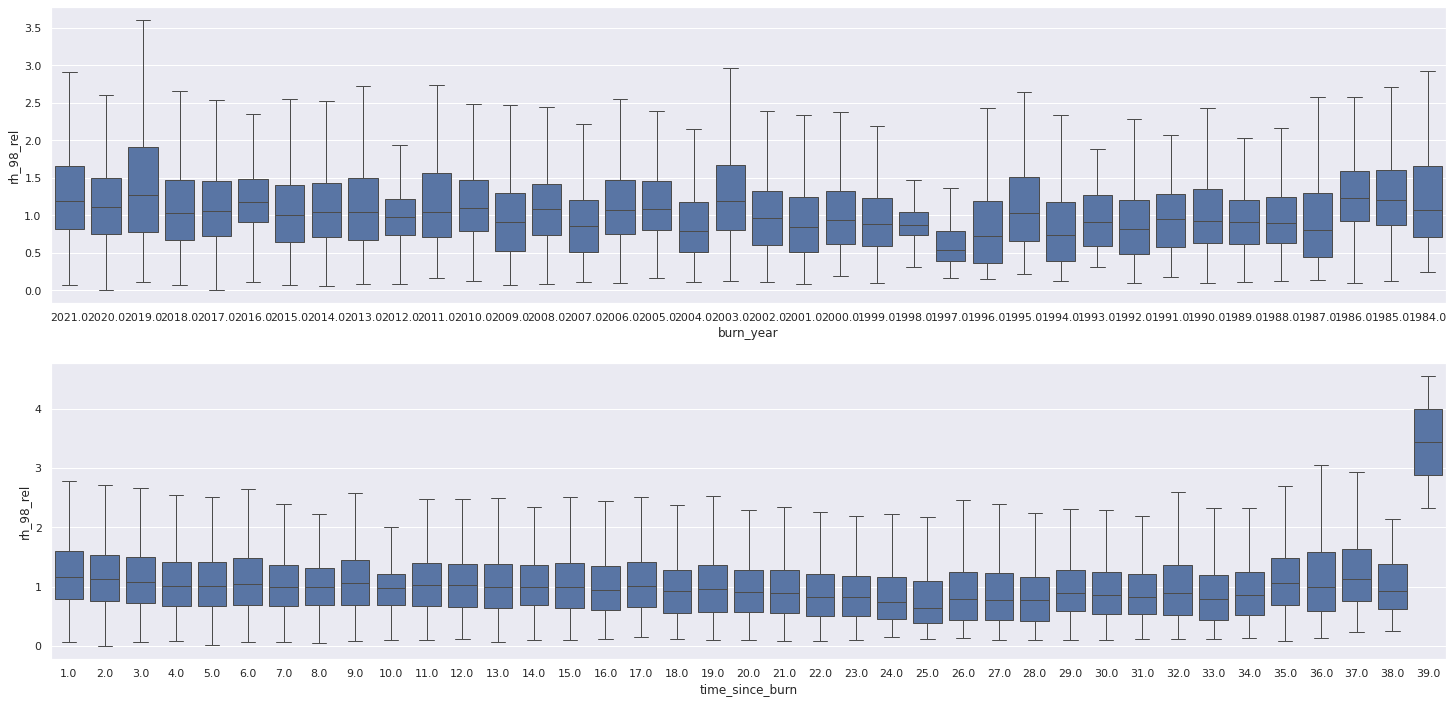

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.boxplot(low_severity, x="burn_year", y="rh_98_rel",  ax=ax[0], showfliers=False)
ax[0].invert_xaxis()
sns.boxplot(low_severity, x="time_since_burn", y="rh_98_rel",  ax=ax[1], showfliers=False)

In [44]:
years_0_5 = low_severity[low_severity.time_since_burn < 6]

(0.0, 2.0)

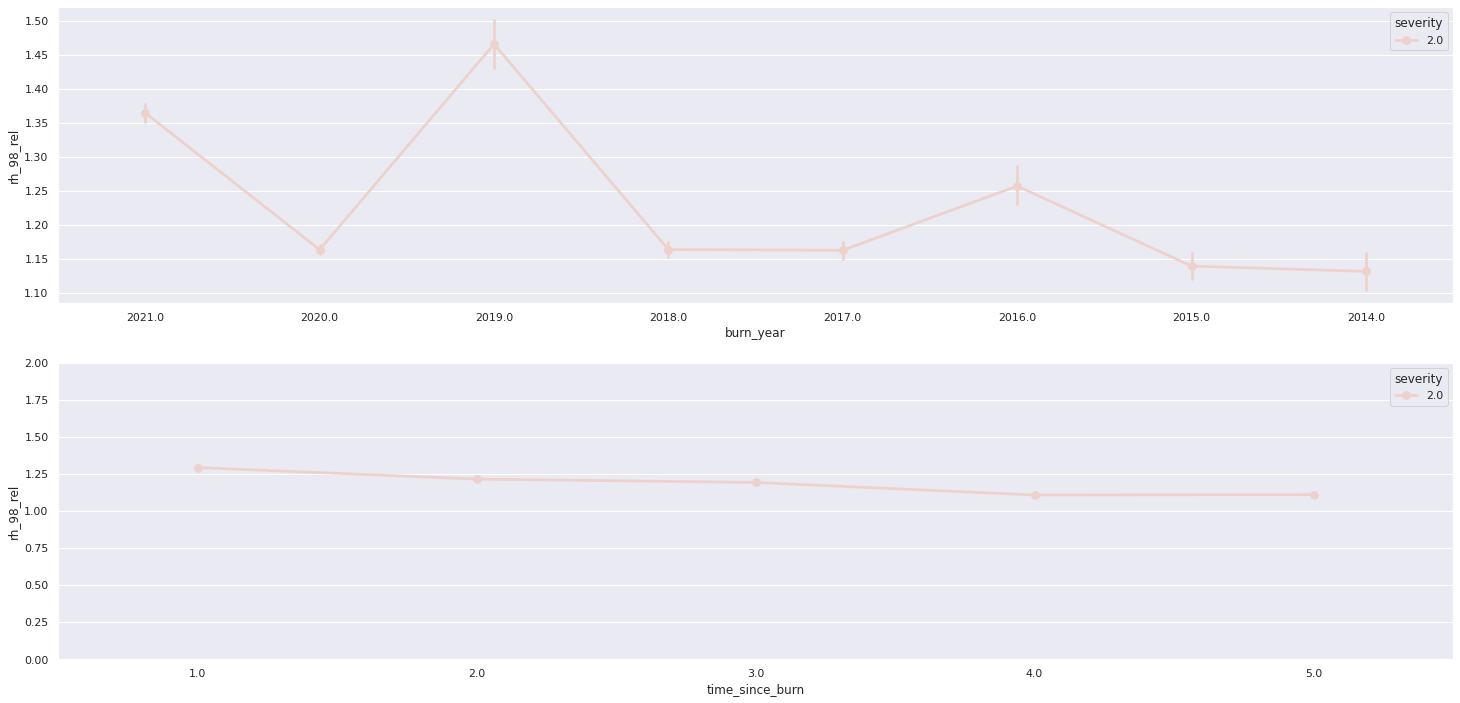

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.pointplot(years_0_5, x="burn_year", y="rh_98_rel", hue="severity", ax=ax[0])
ax[0].invert_xaxis()
sns.pointplot(years_0_5, x="time_since_burn", y="rh_98_rel", hue="severity", ax=ax[1])
ax[1].set_ylim((0, 2))

<AxesSubplot: xlabel='time_since_burn', ylabel='rh_98_rel'>

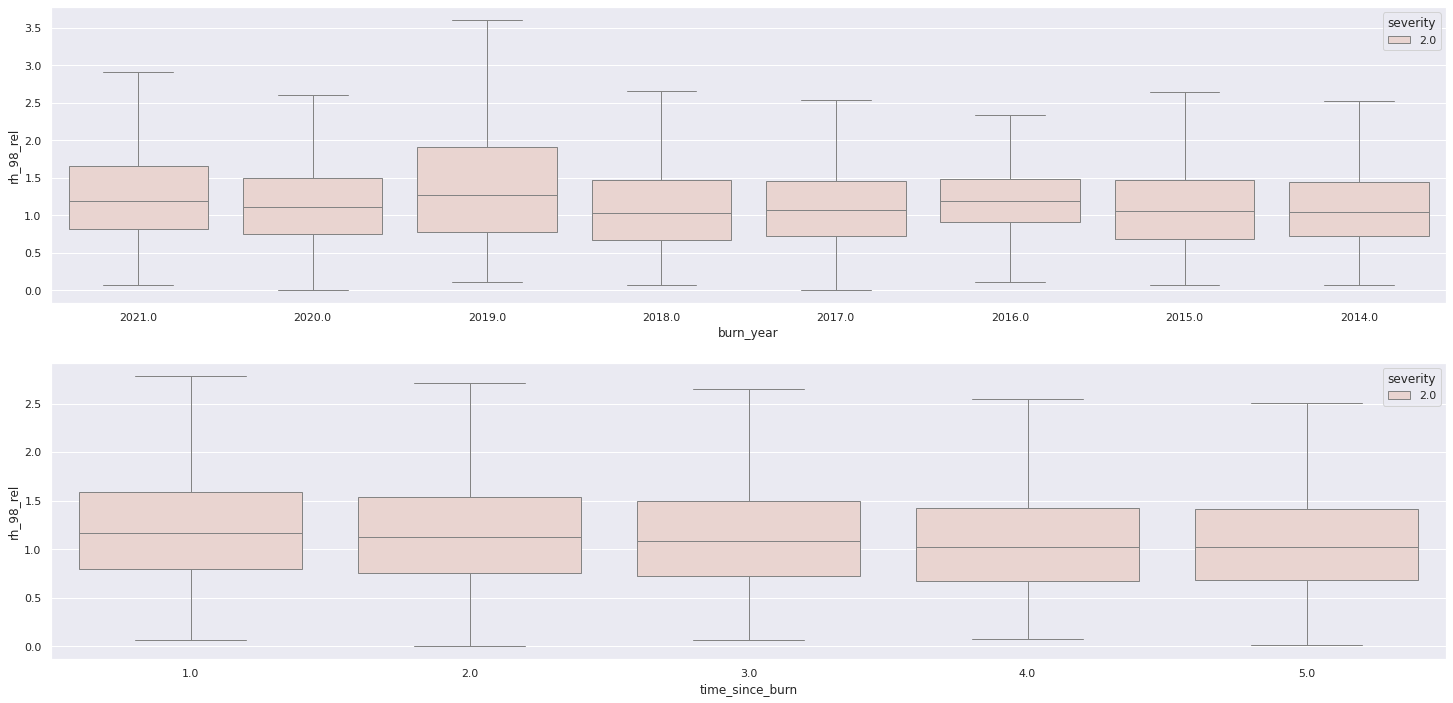

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.boxplot(years_0_5, x="burn_year", y="rh_98_rel", hue="severity", ax=ax[0], showfliers=False)
ax[0].invert_xaxis()
sns.boxplot(years_0_5, x="time_since_burn", y="rh_98_rel", hue="severity", ax=ax[1], showfliers=False)

<AxesSubplot: xlabel='time_since_burn', ylabel='rh_98_rel'>

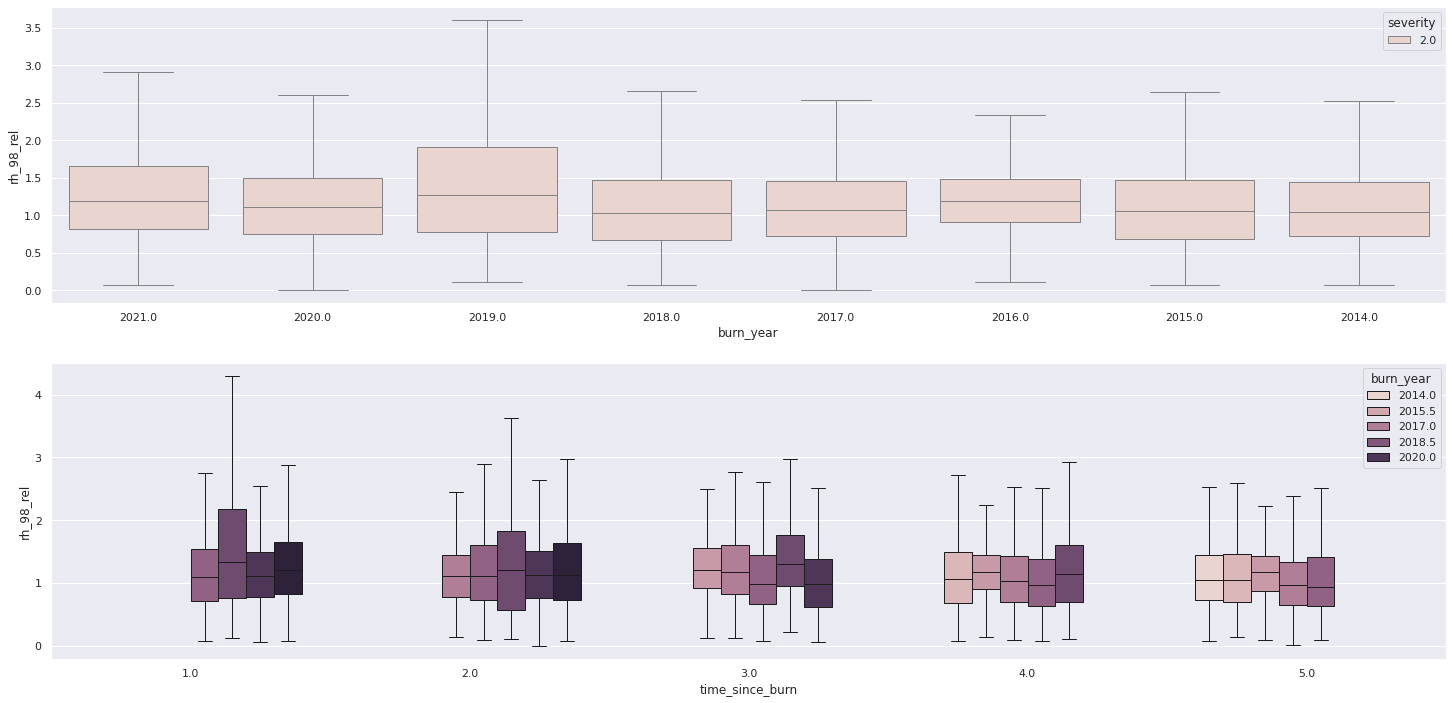

In [51]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.boxplot(years_0_5, x="burn_year", y="rh_98_rel", hue="severity", ax=ax[0], showfliers=False)
ax[0].invert_xaxis()
sns.boxplot(years_0_5, x="time_since_burn", y="rh_98_rel", hue="burn_year", ax=ax[1], showfliers=False)

<AxesSubplot: xlabel='time_since_burn', ylabel='rh_98_control'>

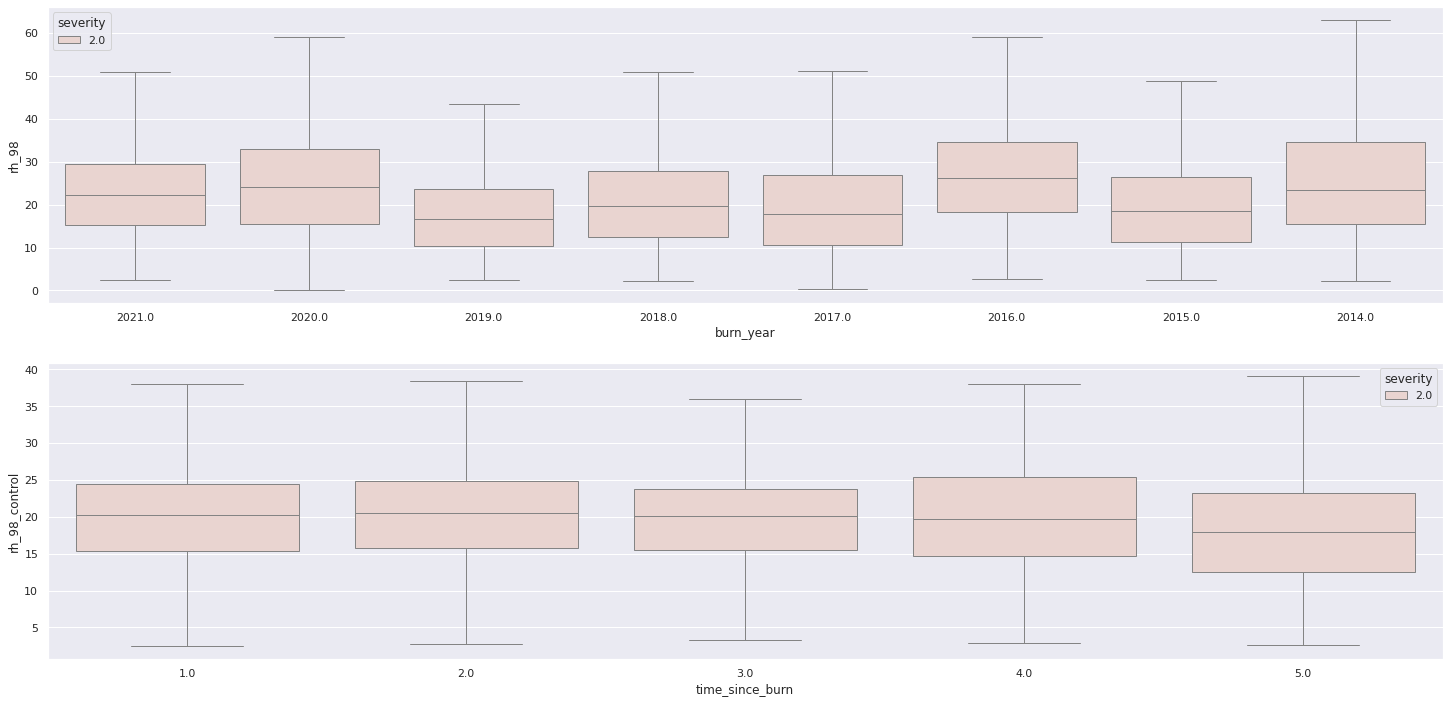

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.boxplot(years_0_5, x="burn_year", y="rh_98", hue="severity", ax=ax[0], showfliers=False)
ax[0].invert_xaxis()
sns.boxplot(years_0_5, x="time_since_burn", y="rh_98_control", hue="severity", ax=ax[1], showfliers=False)

# RH_98 dependence with other variables

(0.0, 2.0)

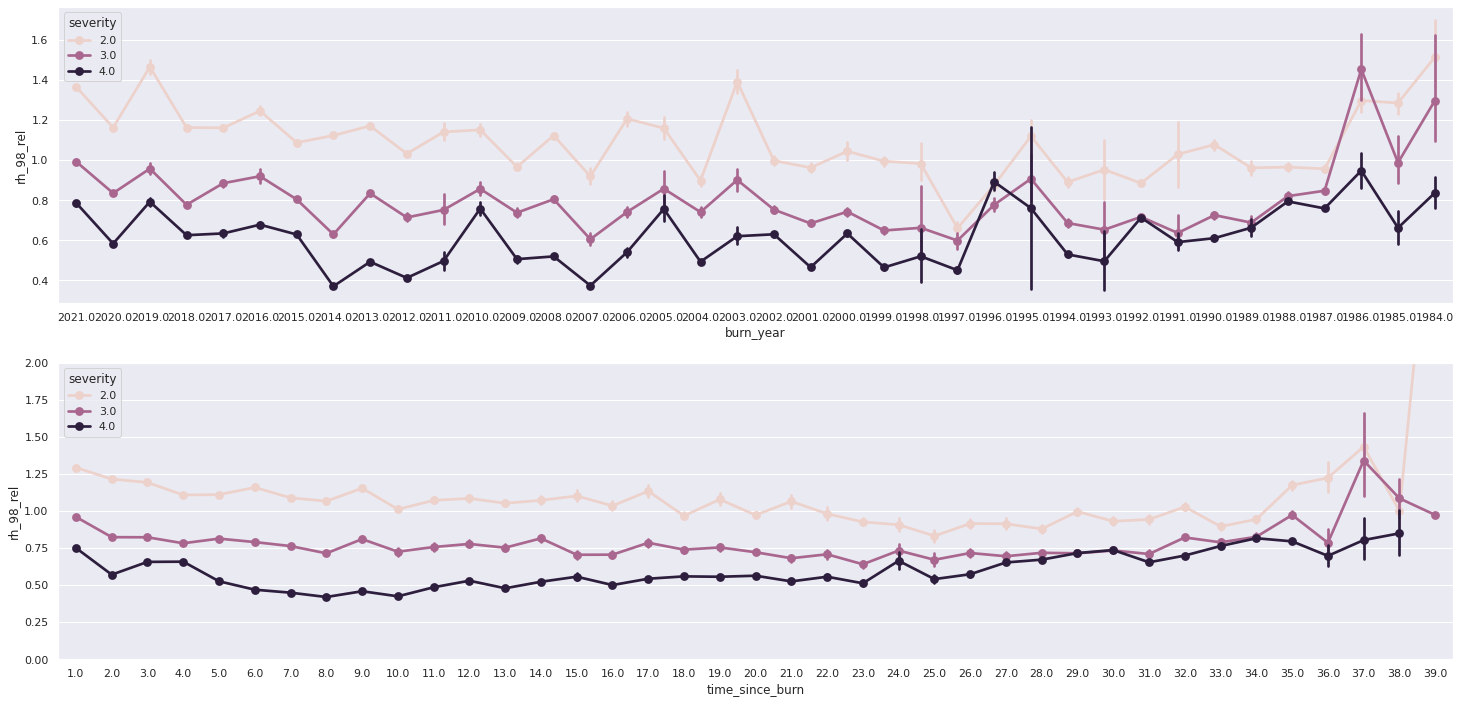

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.pointplot(gedi_burned, x="burn_year", y="rh_98_rel", hue="severity", ax=ax[0])
ax[0].invert_xaxis()
sns.pointplot(gedi_burned, x="time_since_burn", y="rh_98_rel", hue="severity", ax=ax[1])
ax[1].set_ylim((0, 2))

<AxesSubplot: xlabel='time_since_burn', ylabel='Count'>

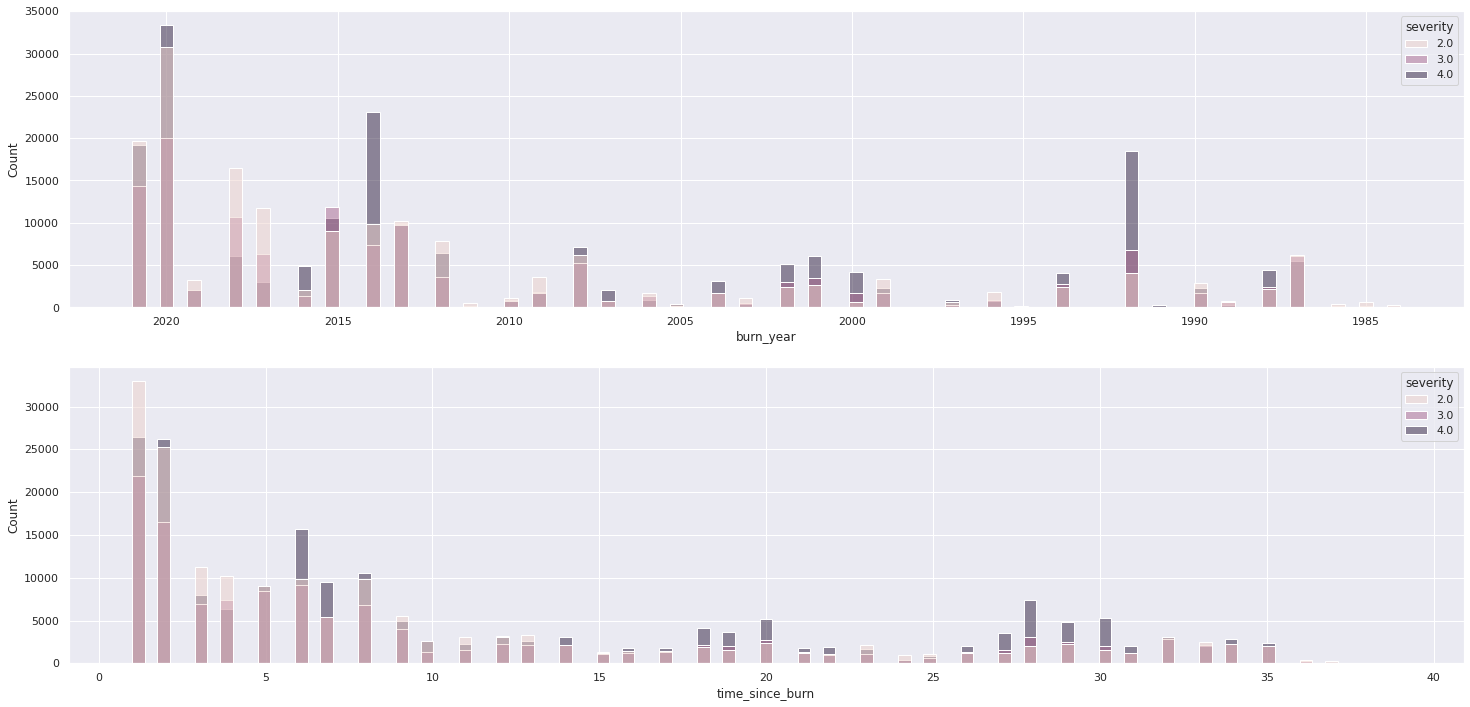

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.histplot(gedi_burned, x="burn_year", hue="severity", ax=ax[0])
ax[0].invert_xaxis()
sns.histplot(gedi_burned, x="time_since_burn", hue="severity", ax=ax[1])

<AxesSubplot: xlabel='time_since_burn', ylabel='rh_98'>

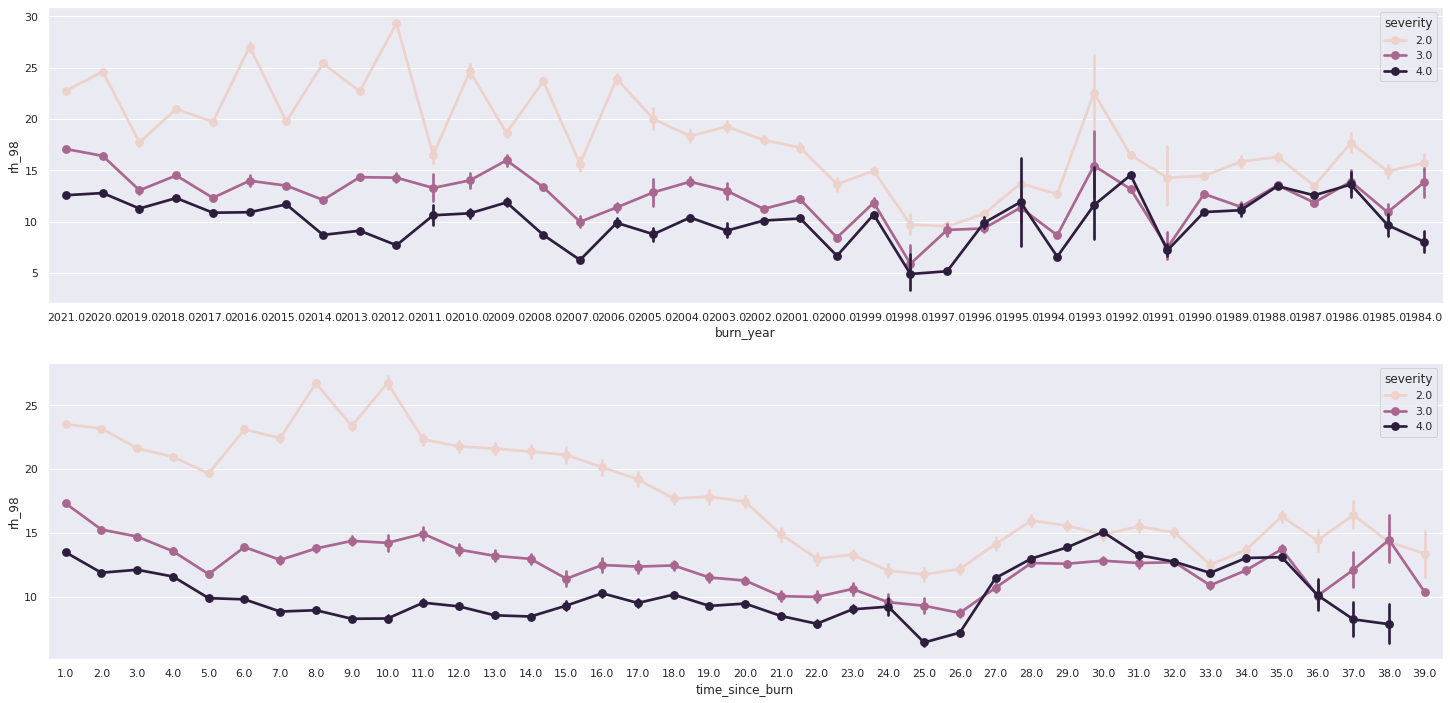

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
sns.pointplot(gedi_burned, x="burn_year", y="rh_98", hue="severity", ax=ax[0])
ax[0].invert_xaxis()
sns.pointplot(gedi_burned, x="time_since_burn", y="rh_98", hue="severity", ax=ax[1])

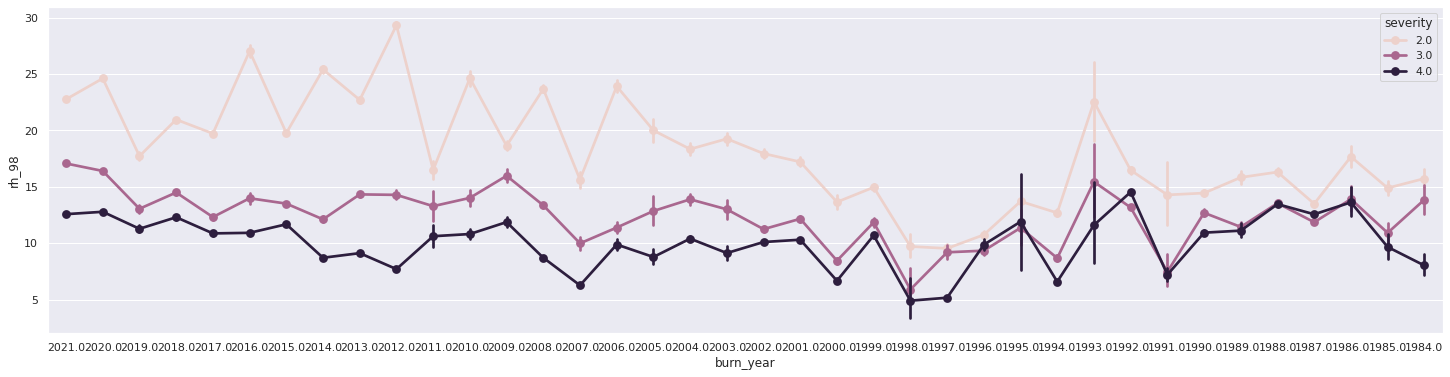

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.pointplot(gedi_burned, x="burn_year", y="rh_98", hue="severity")
ax.invert_xaxis()

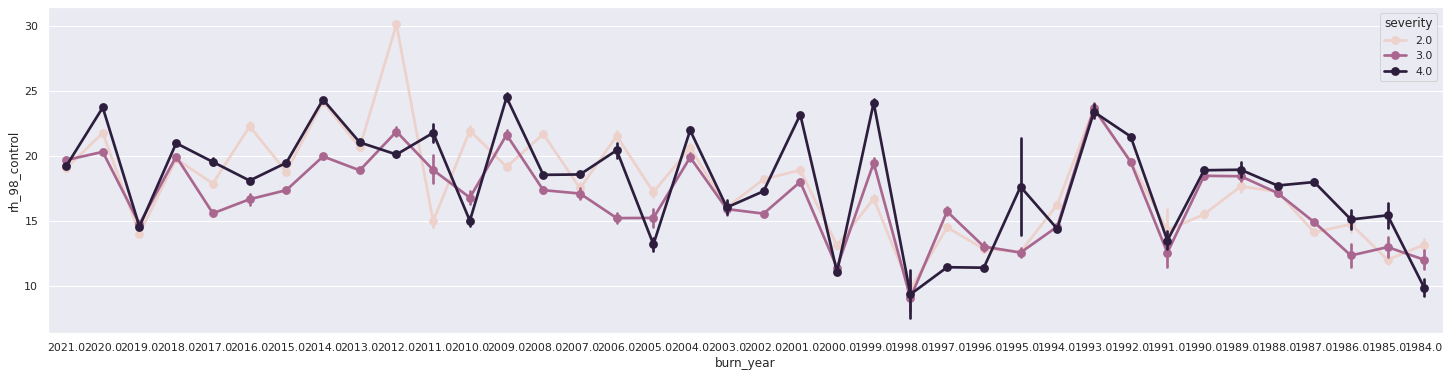

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.pointplot(gedi_burned, x="burn_year", y="rh_98_control", hue="severity")
ax.invert_xaxis()

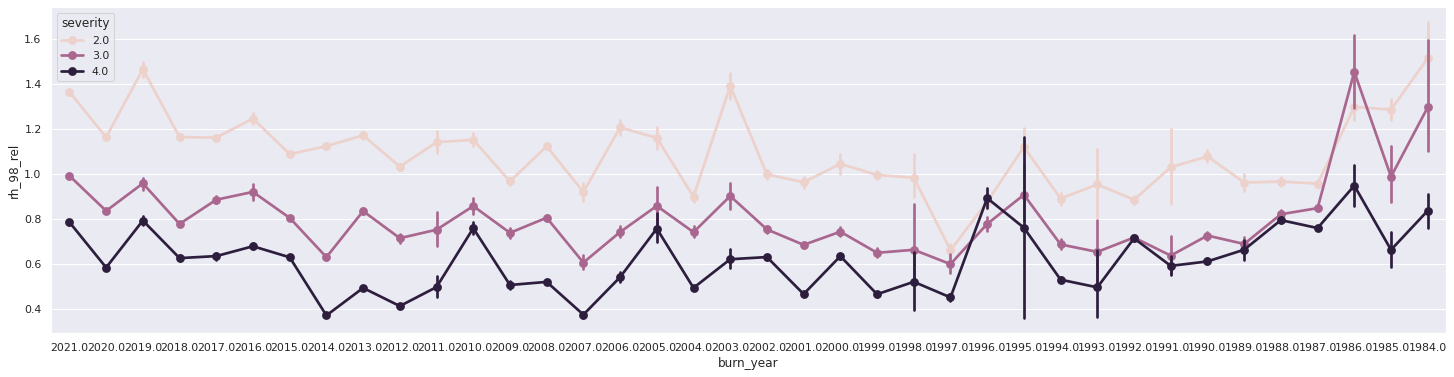

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.pointplot(gedi_burned, x="burn_year", y="rh_98_rel", hue="severity")
ax.invert_xaxis()

<AxesSubplot: xlabel='time_since_burn', ylabel='rh_98'>

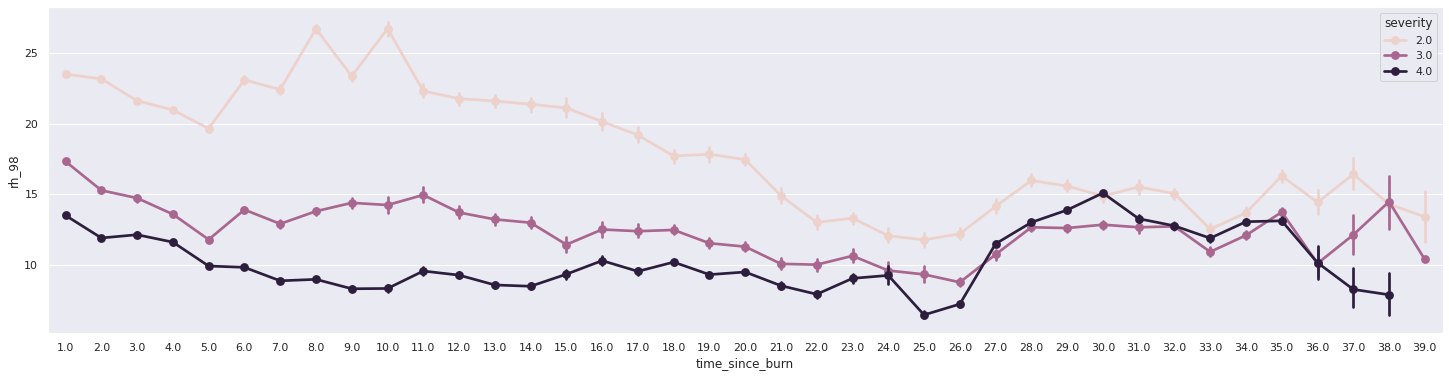

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.pointplot(gedi_burned, x="time_since_burn", y="rh_98", hue="severity")

<AxesSubplot: xlabel='time_since_burn', ylabel='rh_98_control'>

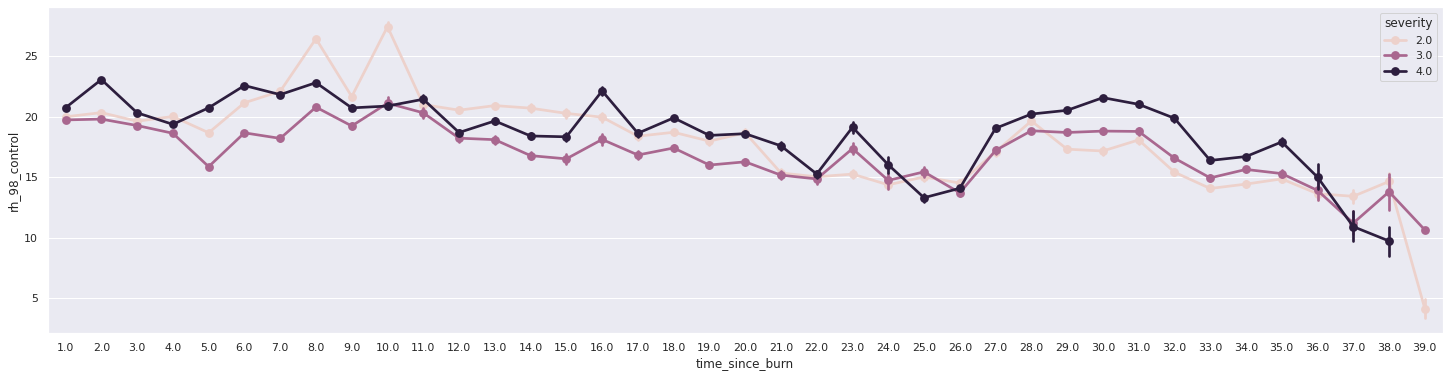

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.pointplot(gedi_burned, x="time_since_burn", y="rh_98_control", hue="severity")

(0.0, 2.0)

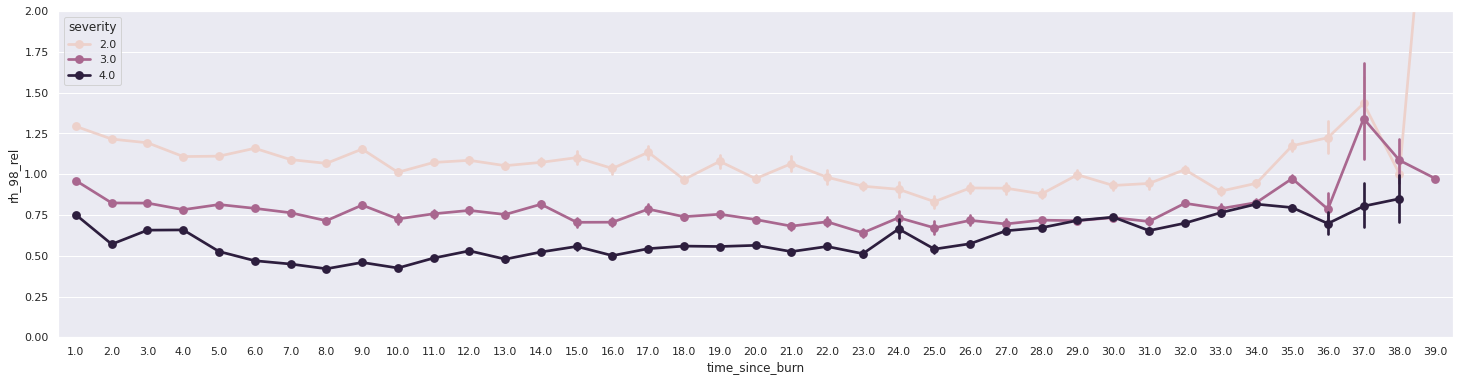

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.pointplot(gedi_burned, x="time_since_burn", y="rh_98_rel", hue="severity")
ax.set_ylim((0, 2))

(0.0, 2.0)

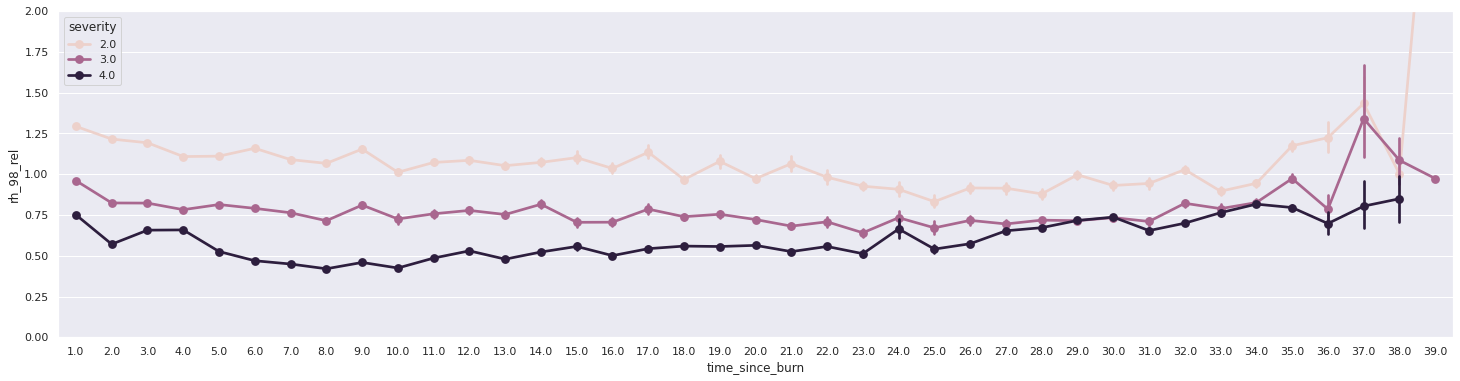

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.pointplot(gedi_burned, x="time_since_burn", y="rh_98_rel", hue="severity")
ax.set_ylim((0, 2))

(0.0, 2.0)

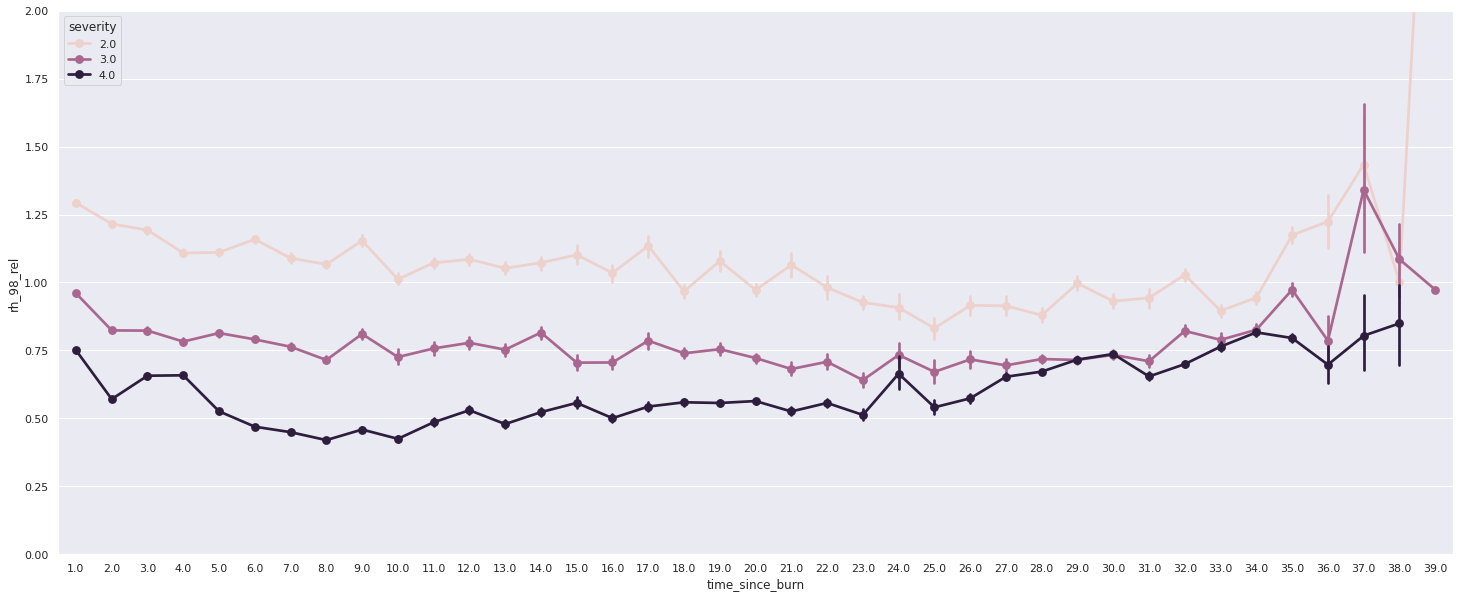

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.pointplot(gedi_burned, x="time_since_burn", y="rh_98_rel", hue="severity")
ax.set_ylim((0, 2))

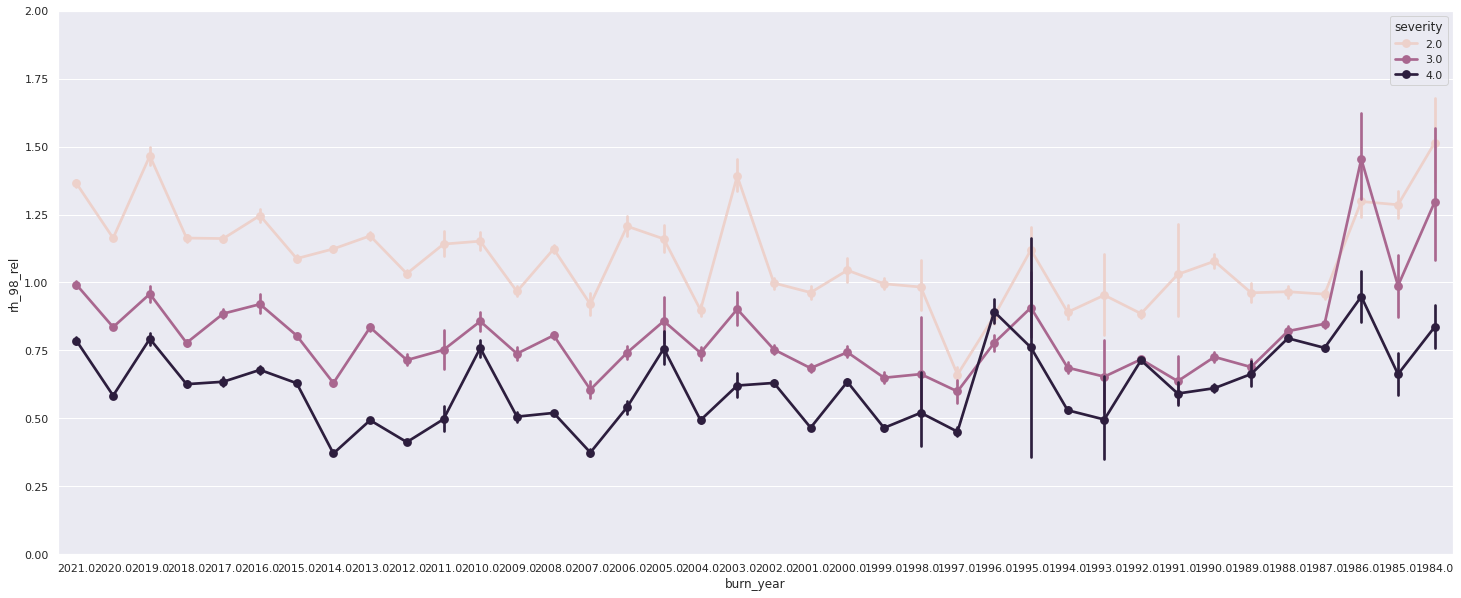

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.pointplot(gedi_burned, x="burn_year", y="rh_98_rel", hue="severity")
ax.set_ylim((0, 2))
ax.invert_xaxis()

190464


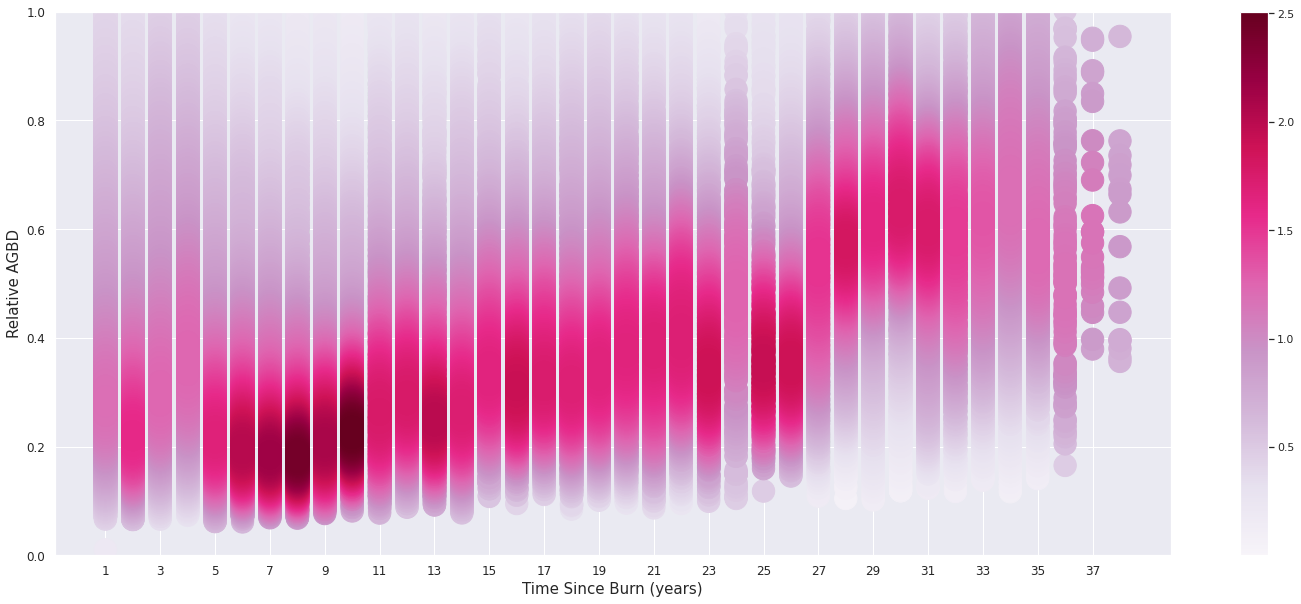

In [52]:
plot_pdf(gedi_burned[gedi_burned.severity == 4],
         'time_since_burn',
         'rh_98_rel',
         "Time Since Burn (years)",
         "Relative AGBD",
         (0, 1))

170085


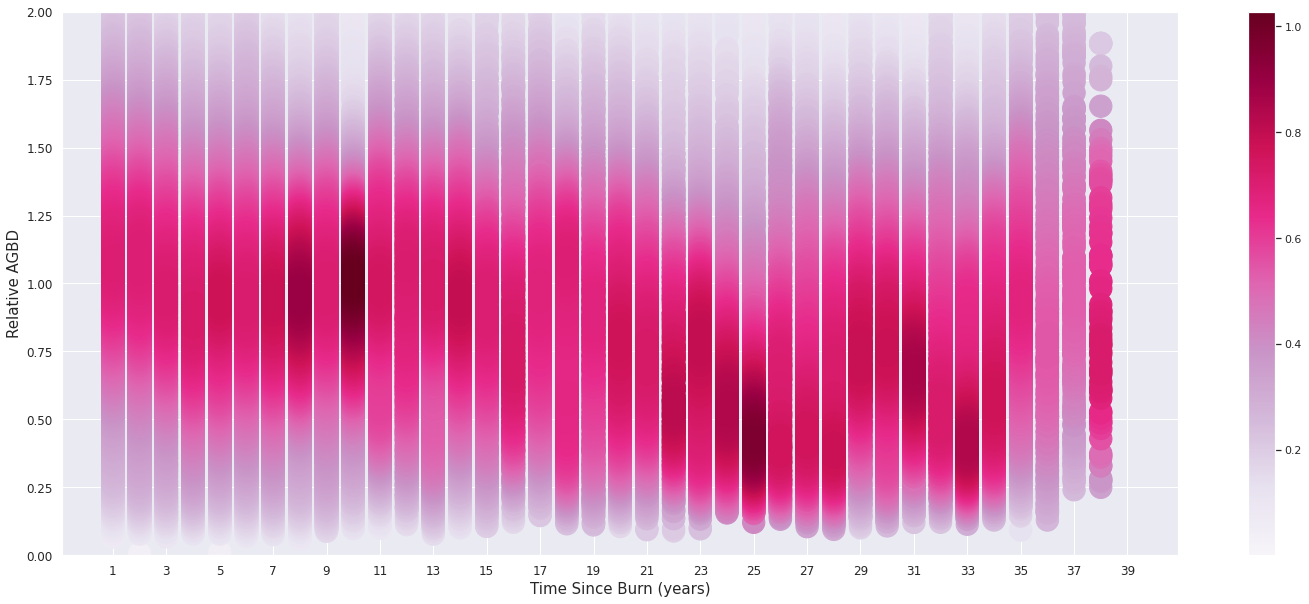

In [54]:
plot_pdf(gedi_burned[gedi_burned.severity == 2],
         'time_since_burn',
         'rh_98_rel',
         "Time Since Burn (years)",
         "Relative AGBD",
         (0, 2))

131695


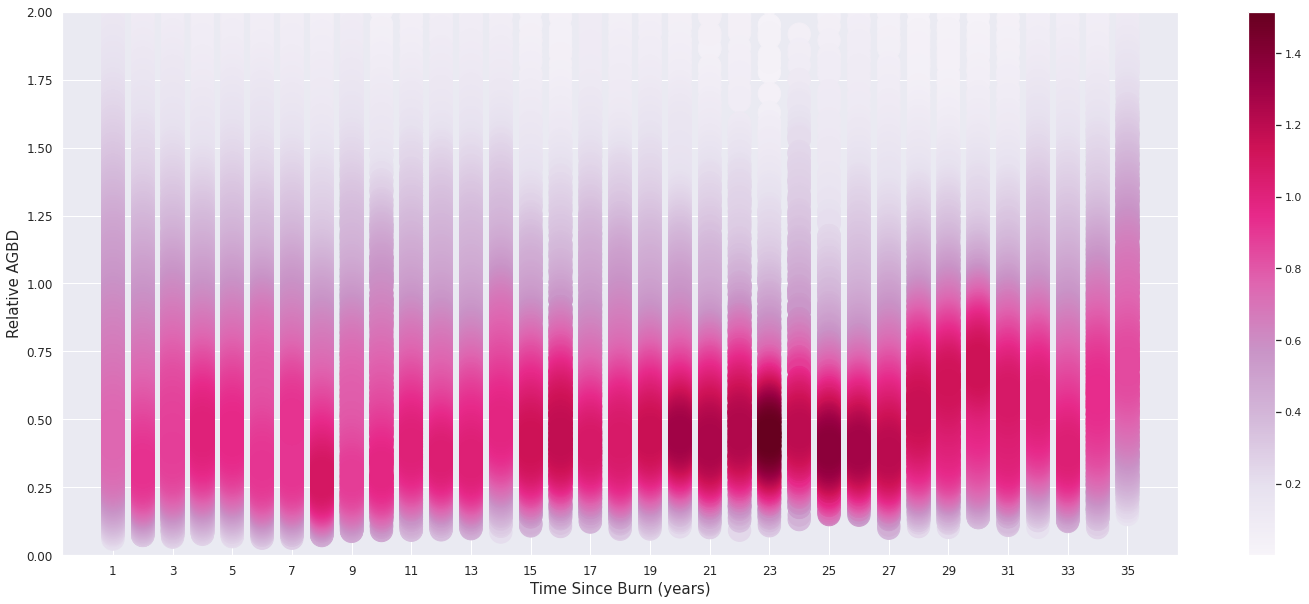

In [57]:
plot_pdf(gedi_burned[(gedi_burned.severity == 3) & (gedi_burned.time_since_burn < 36)],
         'time_since_burn',
         'rh_98_rel',
         "Time Since Burn (years)",
         "Relative AGBD",
         (0, 2))

491242


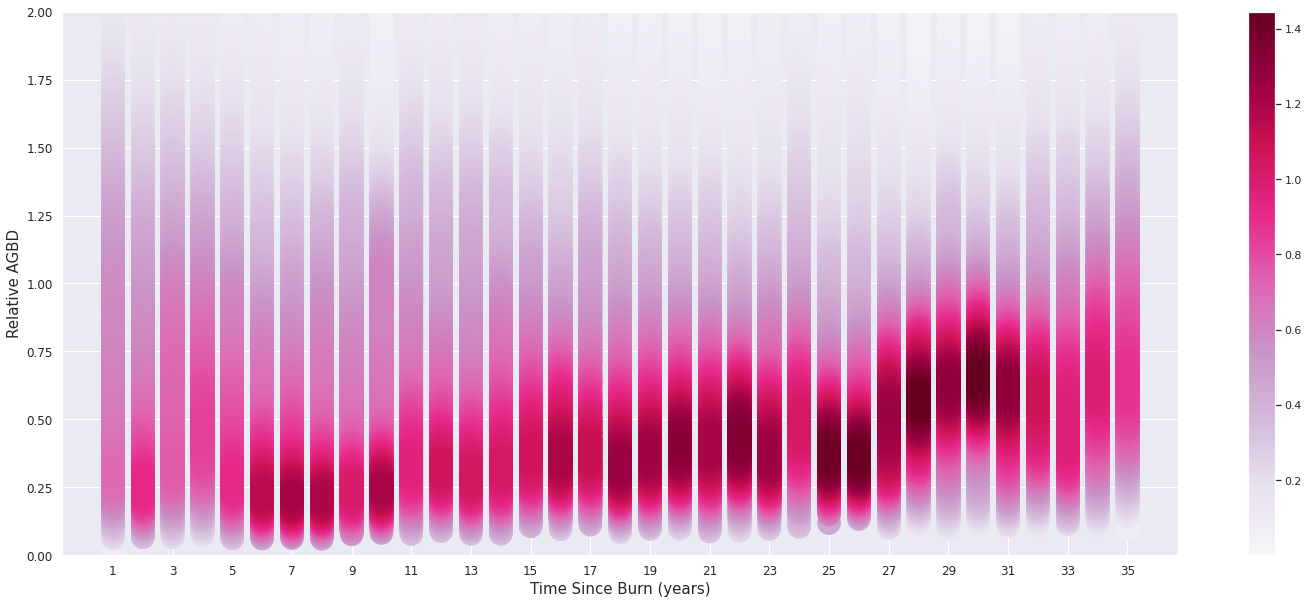

In [58]:
plot_pdf(gedi_burned[(gedi_burned.time_since_burn < 36)],
         'time_since_burn',
         'rh_98_rel',
         "Time Since Burn (years)",
         "Relative AGBD",
         (0, 2))

In [ ]:
plot_pdf(gedi_burned[gedi_burned.severity == 3],
         'time_since_burn',
         'rh_98_rel',
         "Time Since Burn (years)",
         "Relative AGBD",
         (0, 2))

<AxesSubplot: xlabel='time_since_burn', ylabel='rh_70_rel'>

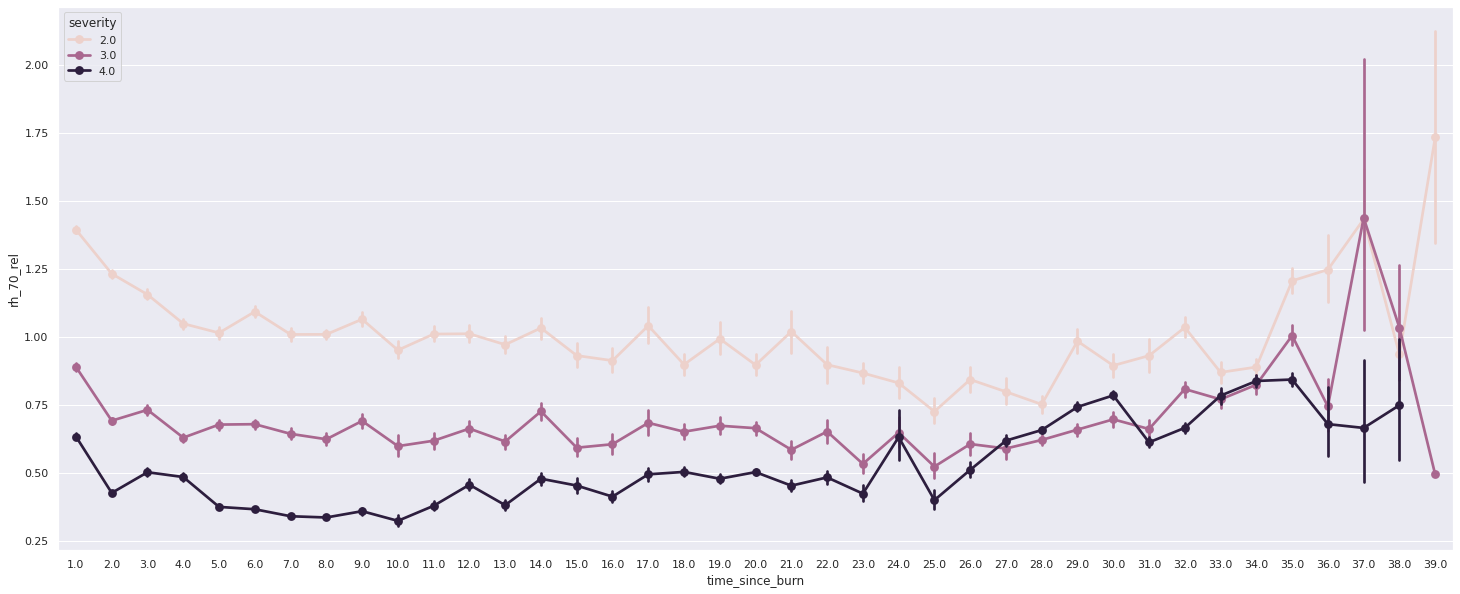

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.pointplot(gedi_burned, x="time_since_burn", y="rh_70_rel", hue="severity")

<AxesSubplot: xlabel='time_since_burn', ylabel='rh_70_control'>

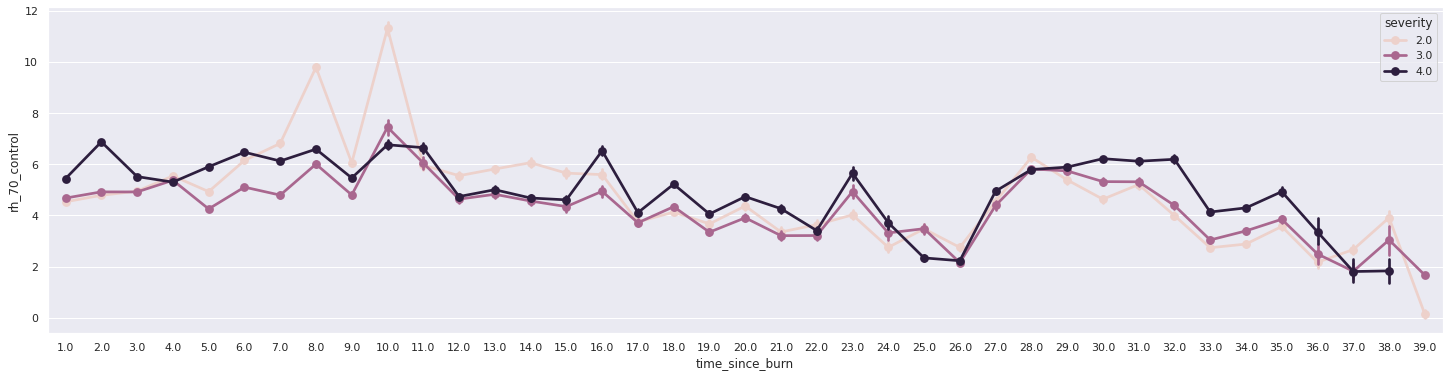

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.pointplot(gedi_burned, x="time_since_burn", y="rh_70_control", hue="severity")

(0.0, 2.0)

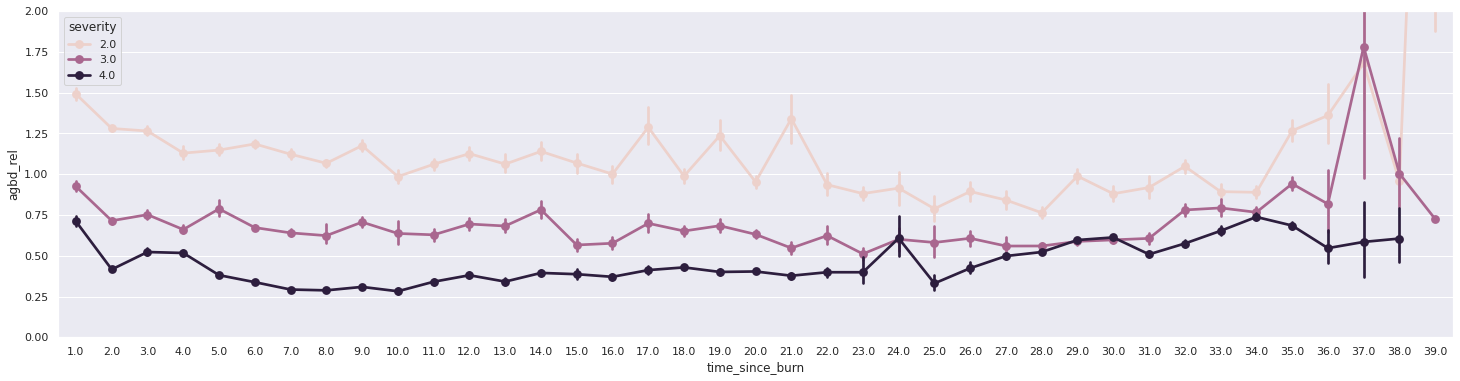

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.pointplot(gedi_burned, x="time_since_burn", y="agbd_rel", hue="severity")
ax.set_ylim((0, 2))

<AxesSubplot: xlabel='time_since_burn', ylabel='NDVI_mean'>

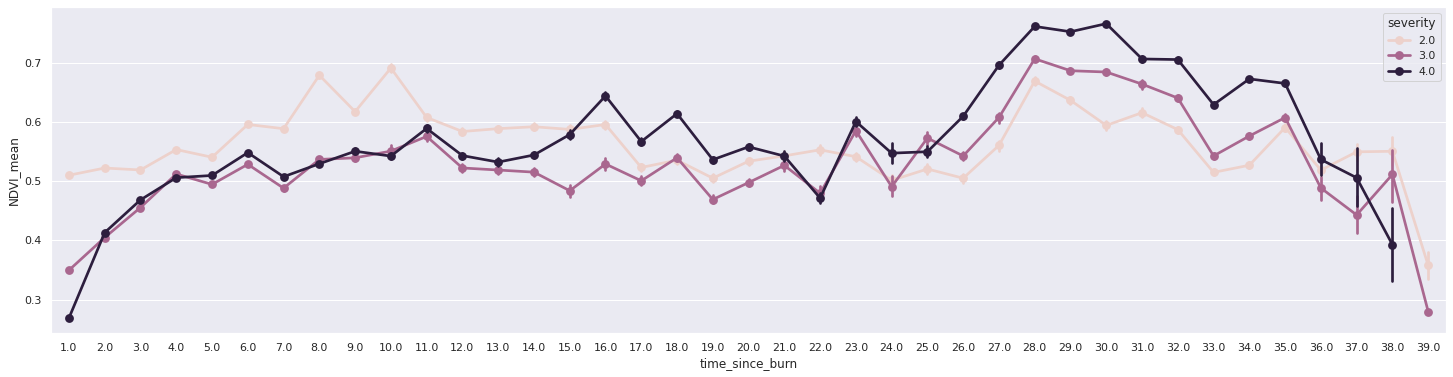

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.pointplot(gedi_burned, x="time_since_burn", y="NDVI_mean", hue="severity")

In [1]:
GEDI_PATH = f"{DATA_PATH}/gedi_intermediate"
save_pickle(
    f"{GEDI_PATH}/sierras_gedi_combined_stage_11_burned_with_controls_Oct28.pkl",
    gedi_burned)

NameError: name 'DATA_PATH' is not defined